# Proyecto de analisis de datos para pronostico de ventas

Este proyecto fue desarrollado para brindar una guía metodológica para generar modelado que permita el pronóstico de ventas. 
En caso de dudas puedes contactarnos y ver la información adicional que se encuentra en el `README.md` de este proyecto. 

**Contexto de negocios.** La apertura económica en Colombia ha afectado a varios sectores económicos por el aumento de la competencia, producto de ello se puede ver la disminución desde 1991 del crecimiento de las exportaciones colombianas, originando a su vez una necesidad por parte de la industria de generar estrategias para ser más competitivos, desarrollando modelos adecuados para los mercados emergentes, enfocados a la mejora de la productividad.

**Problema de negocio.** Se propone una investigación de los sectores críticos de la organización, comenzando con el reconocimiento de los componentes claves para este, luego se estudiarán factores que no se tomaron en cuenta para crear nuevos elementos que generan información más eficiente, útil y que se adapte a los periodos de tiempo requeridos, detectando problemas dentro del área de producción con sus respectivas causas y consecuencias. Posteriormente se procederá a analizar la información recolectada para la generación de propuestas de soluciones. Por último, se elegirán soluciones tanto a corto como a largo plazo, se procede a su desarrollo a manera de modelos que puedan ser implementados.

**Pregunta problema.** ¿Qué factores, motivos y circunstancias inciden en la gestión o planificación de la producción en el sector calzado y como se puede contribuir desde el análisis de datos a su gestión?

# Carga de bibliotecas
En esta sección de subirán los paquetes necesarios para el tratamiento, transformación, visualización y demás procesos permitentes en nuestra data

In [22]:
%%capture

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import math
# Graficos
# ==============================================================================
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import style
from pandas_profiling import ProfileReport
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import plotly.express as px


In [2]:
%%capture
# Forecasting series de tiempo
# ==============================================================================
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [3]:
%%capture
# Utilitarios
# ==============================================================================
from datetime import datetime
from numpy.linalg import LinAlgError
from numpy.linalg import LinAlgError
from copy import deepcopy

In [4]:
%%capture
# Modelado y Forecasting
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor


In [5]:
%%capture
# Otros
# ==============================================================================
import multiprocessing
import time
#from fitter import Fitter
from datetime import datetime
from threading import Timer
import warnings
warnings.filterwarnings('ignore')

In [6]:
%%capture

# Instalación librería skforecast
# ==============================================================================
!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1
# ==============================================================================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [7]:
print("Pandas Version: ", pd.__version__)
print("Numpy Version: ", np.__version__)

Pandas Version:  1.3.5
Numpy Version:  1.21.6


# Funciones

In [8]:
def month_between(d1, d2):
  d1 = datetime.strptime(d1, "%Y/%m/%d")
  d2 = datetime.strptime(d2, "%Y/%m/%d")
  return math.ceil((d2 - d1).days/30)
  
def cambioTipo (dataFrame, columna, tipo):
  """Cambio tipo de dato por columna"""
  dataFrame[columna]= dataFrame[columna].astype(tipo)
  return dataFrame

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return (corr_mat)

def graficarDistribuciones (dataFrame, columna):
  """Grafica la variable obetivo decaurdo a distribuciones comunes"""
  fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
  sns.distplot(
      dataFrame[columna],
      hist    = False,
      rug     = True,
      kde_kws = {'shade': True, 'linewidth': 1},
      ax      = axes[0]
  )
  axes[0].set_title("Distribución original-MENSUAL", fontsize = 'medium')
  axes[0].set_xlabel('pares', fontsize='small') 
  axes[0].tick_params(labelsize = 6)

  sns.distplot(
      np.sqrt(dataFrame[columna]),
      hist    = False,
      rug     = True,
      kde_kws = {'shade': True, 'linewidth': 1},
      ax      = axes[1]
  )
  axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
  axes[1].set_xlabel('sqrt(pares)', fontsize='small') 
  axes[1].tick_params(labelsize = 6)

  sns.distplot(
      np.log(dataFrame[columna]),
      hist    = False,
      rug     = True,
      kde_kws = {'shade': True, 'linewidth': 1},
      ax      = axes[2]
  )
  axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
  axes[2].set_xlabel('log(pares)', fontsize='small') 
  axes[2].tick_params(labelsize = 6)

  fig.tight_layout()

In [9]:


def eliminarFrecuencia (dataFrame, frecuencia, columna):
  """ Funcion que elimina las filas de los registros con una frecuencia menor a la ingresada
  """
  dataFrame=dataFrame[dataFrame.groupby(columna)[columna].transform('count').ge(frecuencia)]
  return dataFrame

def rmsle(y_real, y_prediccion):
  """Logaritmo Raíz Cuadrada del Error Cuadrático Medio"""
  return np.sqrt(mean_squared_log_error(y_real, y_prediccion))

def rmse(y_real, y_prediccion):
  """ Raíz Cuadrada del Error Cuadrático Medio"""
  return mean_squared_error(y_real, y_prediccion, squared=False)

def mae(y_real, y_prediccion): 
  """ MAE"""
  return mean_absolute_error(y_real, y_prediccion)

def mse(y_real, y_prediccion): 
  """ MSE"""
  return mean_squared_error(y_real, y_prediccion)

def mape(y_real, y_prediccion): 
  """ MAPE"""
  return mean_absolute_percentage_error(y_real, y_prediccion)

def r2(y_real, y_prediccion):
  "R2 (coefficient of determination) regression score function."
  return r2_score(y_real, y_prediccion)

def rae(y_real, y_prediccion):
  "Relative Absolute Error"
  result = np.sum(np.abs(np.subtract(y_real, y_prediccion))) / np.sum(np.abs(np.subtract(y_real, np.mean(y_real))))
  return result

def cambiarOneHot (dataFrame, columnas):
  """
  Cambia las variables categorias en representativas para regresion
  """
  for col in columnas:
    dummy = pd.get_dummies(dataFrame[col], prefix = col, drop_first = False)
    dataFrame = pd.concat([dataFrame, dummy], axis = 1)
  return dataFrame


def completarDataCeros (dataFrame, agrupacionCol, fecha_maxima, frecuencia):
  """Funcion que llena los datos faltantes desde el primer registro (de cada 
  'agrupacion')hasta el ultmo con ceros
  dataFrame: conjunto de datos
  agrupacionCol: caracteristica por la cual se quiere agrupar. Entre comillas
  fechaamaxima: fecha mas reciente del conjunto general de datos. formato data
  frecuencia: frecuencia a la cual se quiere completar el dataframe. Entre 
  comillas. "D", "M", "W"...
   """
  diario_groupbyThing = dataFrame.groupby([agrupacionCol, 'fecha'])['ventas_pares'].sum()
  diario_groupbyThing = diario_groupbyThing.reset_index()
  reference_list = diario_groupbyThing[agrupacionCol].unique().tolist()
  dataframeRelleno = pd.DataFrame()

  for i in reference_list:
    dataframe = diario_groupbyThing[diario_groupbyThing[agrupacionCol]==i]
    fecha_minima = datetime.fromisoformat(str(dataframe["fecha"].min()))
    dataframe = dataframe.set_index('fecha')
    dataframe.index = pd.DatetimeIndex(dataframe.index)
    ix = pd.date_range(name="fecha", start=fecha_minima, end=fecha_maxima, freq=frecuencia)
    dataframe = dataframe.reindex(ix, fill_value=0)
    dataframe[agrupacionCol] = dataframe[agrupacionCol].replace({0:i})
    dataframeRelleno = pd.concat([dataframeRelleno,dataframe])

  dataframeRelleno = dataframeRelleno.reset_index()
  return dataframeRelleno



def modelarMensual(dataFrame, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccionRF = []
  list_evaluacionRF = []
  list_scoreRF = []

  list_y_prediccionBF = []
  list_evaluacionBF = []
  list_scoreBF = []

  list_y_prediccionAF = []
  list_evaluacionAF = []
  list_scoreAF = []

  list_y_prediccionLR = []
  list_evaluacionLR = []
  list_scoreLR = []

  list_y_prediccionLogR = []
  list_evaluacionLogR = []
  list_scoreLogR = []
  
  vacio =[]


  for item, informacion in df.groupby(agrupacionCol):
    things.append(item)

    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()

    le_descripcion_dia = LabelEncoder()
    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    X = datos_entrada
    y = datos_salida
    X_trainF, X_validationF, y_trainF, y_validationF = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccionRF, scoreRF, evaluacionRF = modelarRandomForest(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)

      list_scoreRF.append(scoreRF)
      list_evaluacionRF.append(evaluacionRF)
    except:

      list_scoreRF.append(vacio)
      list_evaluacionRF.append(vacio)

    try:
      y_prediccionBF, scoreBF, evaluacionBF = modelarBaggingRegressor(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)

      list_scoreBF.append(scoreBF)
      list_evaluacionBF.append(evaluacionBF)
    except:

      list_scoreBF.append(vacio)
      list_evaluacionBF.append(vacio)

    try:
      y_prediccionAF, scoreAF, evaluacionAF = modelarAdaBoostRegressor(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)

      list_scoreAF.append(scoreAF)
      list_evaluacionAF.append(evaluacionAF)
    except:

      list_scoreAF.append(vacio)
      list_evaluacionAF.append(vacio)


    columnas_categoricas = [ "num_mes", "num_año"]
    diario_OneHot = cambiarOneHot(informacion, columnas_categoricas)
    diario_OneHot = diario_OneHot.drop(columnas_categoricas, axis=1)

    X = diario_OneHot.drop(['ventas_pares', 'fecha', agrupacionCol], axis=1)
    y = diario_OneHot.loc[:,['ventas_pares']]
    X_trainOH, X_validationOH, y_trainOH, y_validationOH = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccionL, scoreL, evaluacionL = modelarLinearReg(X_trainOH, X_validationOH, y_trainOH, y_validationOH, metricaEval)

      list_scoreLR.append(scoreL)
      list_evaluacionLR.append(evaluacionL)
    except:
 
      list_scoreLR.append(vacio)
      list_evaluacionLR.append(vacio)

    try:
      y_prediccionLogR, scoreLogR, evaluacionLogR = modelarLogisticReg(X_trainOH, X_validationOH, y_trainOH, y_validationOH, metricaEval)

      list_scoreLogR.append(scoreLogR)
      list_evaluacionLogR.append(evaluacionLogR)
    except:

      list_scoreLogR.append(vacio)
      list_evaluacionLogR.append(vacio)

  
  return things,  list_scoreRF, list_evaluacionRF, list_scoreBF, list_evaluacionBF, list_scoreAF, list_evaluacionAF, list_scoreLR, list_evaluacionLR,  list_scoreLogR, list_evaluacionLogR
 


def prepararMensual (dataFrame ):
  dataFrame["num_mes"] = dataFrame['fecha'].dt.month.astype('object')
  dataFrame["num_año"] = dataFrame['fecha'].dt.year.astype('object')
  return dataFrame

def modelarRandomForest(X_train, X_validation, y_train, y_validation, metricaEval1):
  modelo = RandomForestRegressor()
  modelo.fit(X_train, y_train)
  y_prediccion = modelo.predict(X_validation)
  error = metricaEval(y_validation, y_prediccion)
  r2 = modelo.score(X_validation, y_validation)
  return y_prediccion, r2, error


def modelarLinearReg(X_train, X_validation, y_train, y_validation, metricaEval):
  modelo = LinearRegression(positive=True)
  modelo.fit(X_train, y_train)
  y_prediccion = modelo.predict(X_validation)
  error = metricaEval(y_validation, y_prediccion)
  r2 = modelo.score(X_validation, y_validation)
  return  y_prediccion, r2, error


def modelarLogisticReg(X_train, X_validation, y_train, y_validation, metricaEval):
  modelo =  LogisticRegression()
  modelo.fit(X_train, y_train)
  y_prediccion = modelo.predict(X_validation)
  error = metricaEval(y_validation, y_prediccion)
  r2 = modelo.score(X_validation, y_validation)
  return  y_prediccion, r2, error

def modelarBaggingRegressor(X_train, X_validation, y_train, y_validation, metricaEval):
  modelo = BaggingRegressor()
  modelo.fit(X_train, y_train)
  y_prediccion = modelo.predict(X_validation)
  error = metricaEval(y_validation, y_prediccion)
  r2 = modelo.score(X_validation, y_validation)
  return  y_prediccion, r2, error

def modelarAdaBoostRegressor(X_train, X_validation, y_train, y_validation, metricaEval):
  modelo = AdaBoostRegressor()
  modelo.fit(X_train, y_train)
  y_prediccion = modelo.predict(X_validation)
  error = metricaEval(y_validation, y_prediccion)
  r2 = modelo.score(X_validation, y_validation)
  return y_prediccion, r2, error



In [10]:


def bagingReview(df, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccion = []
  list_evaluacion = []
  list_score = []

  vacio =[]


  for item, informacion in df.groupby(agrupacionCol):
    things.append(item)

    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    X = datos_entrada
    y = datos_salida
    X_trainF, X_validationF, y_trainF, y_validationF = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccion, score, metricResult = modelarBaggingRegressor(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)
      list_score.append(score)
      list_evaluacion.append(metricResult)
    except:
      list_score.append(vacio)
      list_evaluacion.append(vacio)
  
  return things,  list_score, list_evaluacion

def predictBaggingRegresor(df, agrupacionCol, startDatePredict, endDatePredict):
  """
      dfe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      dates to do predict 
  """
  datePredict = pd.date_range(start=startDatePredict, end=endDatePredict, freq='MS')
  dfPredict = pd.DataFrame(datePredict, columns=['date'])
  dfPredict['Year'] = dfPredict['date'].dt.year
  dfPredict['Month'] = dfPredict['date'].dt.month

  things = []
  predictions = []

  for item, informacion in df.groupby(agrupacionCol):

    things.append(item)
    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()
    datos_predecir = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    le_predict_mes = LabelEncoder()
    le_predict_year = LabelEncoder()
    datos_predecir["mes_codigo"] = le_predict_mes.fit_transform(dfPredict['Month'])
    datos_predecir["año_codigo"] = le_predict_mes.fit_transform(dfPredict['Year'])

    X_train = datos_entrada
    y_train = datos_salida
    X_predict = datos_predecir

    modelo = BaggingRegressor()
    modelo.fit(X_train, y_train)
    y_prediccion = modelo.predict(X_predict)
    predictions.append(y_prediccion)

  return things, predictions

#---------RandomForest-------

def randomReview(df, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccion = []
  list_evaluacion = []
  list_score = []

  vacio =[]


  for item, informacion in df.groupby(agrupacionCol):
    things.append(item)

    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    X = datos_entrada
    y = datos_salida
    X_trainF, X_validationF, y_trainF, y_validationF = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccion, score, metricResult = modelarRandomForest(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)
      list_score.append(score)
      list_evaluacion.append(metricResult)
    except:
      list_score.append(vacio)
      list_evaluacion.append(vacio)
  
  return things,  list_score, list_evaluacion

def preddictRandomForest(df, agrupacionCol, startDatePredict, endDatePredict):
  """
      dfe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      dates to do predict 
  """
  datePredict = pd.date_range(start=startDatePredict, end=endDatePredict, freq='MS')
  dfPredict = pd.DataFrame(datePredict, columns=['date'])
  dfPredict['Year'] = dfPredict['date'].dt.year
  dfPredict['Month'] = dfPredict['date'].dt.month

  things = []
  predictions = []

  for item, informacion in df.groupby(agrupacionCol):

    things.append(item)
    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()
    datos_predecir = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    le_predict_mes = LabelEncoder()
    le_predict_year = LabelEncoder()
    datos_predecir["mes_codigo"] = le_predict_mes.fit_transform(dfPredict['Month'])
    datos_predecir["año_codigo"] = le_predict_mes.fit_transform(dfPredict['Year'])

    X_train = datos_entrada
    y_train = datos_salida
    X_predict = datos_predecir

    modelo = RandomForestRegressor()
    modelo.fit(X_train, y_train)
    y_prediccion = modelo.predict(X_predict)
    predictions.append(y_prediccion)

  return things, predictions

#-------- Addam Regresor ---------

def addamReview(df, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccion = []
  list_evaluacion = []
  list_score = []

  vacio =[]


  for item, informacion in df.groupby(agrupacionCol):
    things.append(item)

    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    X = datos_entrada
    y = datos_salida
    X_trainF, X_validationF, y_trainF, y_validationF = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccion, score, metricResult = modelarAdaBoostRegressor(X_trainF, X_validationF, y_trainF, y_validationF, metricaEval)
      list_score.append(score)
      list_evaluacion.append(metricResult)
    except:
      list_score.append(vacio)
      list_evaluacion.append(vacio)
  
  return things,  list_score, list_evaluacion

def preddictAddam(df, agrupacionCol, startDatePredict, endDatePredict):
  """
      dfe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      dates to do predict 
  """
  datePredict = pd.date_range(start=startDatePredict, end=endDatePredict, freq='MS')
  dfPredict = pd.DataFrame(datePredict, columns=['date'])
  dfPredict['Year'] = dfPredict['date'].dt.year
  dfPredict['Month'] = dfPredict['date'].dt.month

  things = []
  predictions = []

  for item, informacion in df.groupby(agrupacionCol):

    things.append(item)
    datos_salida= informacion.loc[:,['ventas_pares']]
    datos_entrada = pd.DataFrame()
    datos_predecir = pd.DataFrame()

    le_descripcion_mes = LabelEncoder()
    le_descripcion_year = LabelEncoder()

    datos_entrada["mes_codigo"] = le_descripcion_mes.fit_transform(informacion["num_mes"])
    datos_entrada["año_codigo"] = le_descripcion_year.fit_transform(informacion["num_año"])

    le_predict_mes = LabelEncoder()
    le_predict_year = LabelEncoder()
    datos_predecir["mes_codigo"] = le_predict_mes.fit_transform(dfPredict['Month'])
    datos_predecir["año_codigo"] = le_predict_mes.fit_transform(dfPredict['Year'])

    X_train = datos_entrada
    y_train = datos_salida
    X_predict = datos_predecir

    modelo = AdaBoostRegressor()
    modelo.fit(X_train, y_train)
    y_prediccion = modelo.predict(X_predict)
    predictions.append(y_prediccion)

  return things, predictions

#-------- Linear ---------

def linearReview(df, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccion = []
  list_evaluacion = []
  list_score = []

  vacio =[]
  
  for item, informacion in df.groupby(agrupacionCol):

    things.append(item)
    columnas_categoricas = [ "num_mes", "num_año"]
    diario_OneHot = cambiarOneHot(informacion, columnas_categoricas)
    diario_OneHot = diario_OneHot.drop(columnas_categoricas, axis=1)

    X = diario_OneHot.drop(['ventas_pares', 'fecha', agrupacionCol], axis=1)
    y = diario_OneHot.loc[:,['ventas_pares']]
    X_trainOH, X_validationOH, y_trainOH, y_validationOH = train_test_split(X, y, train_size=0.75, random_state=42)

    try:
      y_prediccion, score, metricResult = modelarAdaBoostRegressor(X_trainOH, X_validationOH, y_trainOH, y_validationOH , metricaEval)
      list_score.append(score)
      list_evaluacion.append(metricResult)
    except:
      list_score.append(vacio)
      list_evaluacion.append(vacio)   
  
  return things,  list_score, list_evaluacion



def preddictLinear(df, agrupacionCol, startDatePredict, endDatePredict):
  """
      dfe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      dates to do predict 
  """
  datePredict = pd.date_range(start=startDatePredict, end=endDatePredict, freq='MS')
  dfPredict = pd.DataFrame(datePredict, columns=['date'])
  dfPredict['num_año'] = dfPredict['date'].dt.year.astype('object')
  dfPredict['num_mes'] = dfPredict['date'].dt.month.astype('object')


  things = []
  predictions = []

  for item, informacion in df.groupby(agrupacionCol):
    
    things.append(item)

    t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ["num_mes", "num_año"])], 
                          remainder='passthrough')

    # Transform the features
    features = t.fit_transform(informacion[["num_mes", "num_año"]])
    result = informacion[['ventas_pares']]

    # Train the linear regression model
    reg = LinearRegression(positive=True)
    model = reg.fit(features.todense(), result)

    # Generate a prediction
    

    try:
      example = t.transform(dfPredict[["num_mes", "num_año"]])
      prediction = model.predict(example.todense())
      predictions.append(prediction)
    except(ValueError):
      predictions.append(None)


  return things, predictions

#-------- Logistic---------


def logisticReview(df, agrupacionCol, metricaEval):
  """
      dataframe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      metricaEval: Con cual de las metricas definidas anteriormente se evalua 
  """
  things = []

  list_y_prediccion = []
  list_evaluacion = []
  list_score = []

  
  for item, informacion in df.groupby(agrupacionCol):

    things.append(item)
    columnas_categoricas = [ "num_mes", "num_año"]
    diario_OneHot = cambiarOneHot(informacion, columnas_categoricas)
    diario_OneHot = diario_OneHot.drop(columnas_categoricas, axis=1)

    X = diario_OneHot.drop(['ventas_pares', 'fecha', agrupacionCol], axis=1)
    y = diario_OneHot.loc[:,['ventas_pares']]
    X_trainOH, X_validationOH, y_trainOH, y_validationOH = train_test_split(X, y, train_size=0.75, random_state=42)
    startlog = time.time()

    try:
      y_prediccion, score, metricResult = modelarLogisticReg(X_trainOH, X_validationOH, y_trainOH, y_validationOH , metricaEval)
      list_score.append(score)
      list_evaluacion.append(metricResult)

    except (RuntimeError, TypeError, NameError, ValueError):
      list_score.append(None)
      list_evaluacion.append(None)   
  
  return things,  list_score, list_evaluacion

def preddictLogistic(df, agrupacionCol, startDatePredict, endDatePredict):
  """
      dfe: con agrupacion Diararia sin agrupar
      agrupacionCol: nombre de la columna por la cual se hara la agrupacion <entre comillas>
      dates to do predict 
  """
  datePredict = pd.date_range(start=startDatePredict, end=endDatePredict, freq='MS')
  dfPredict = pd.DataFrame(datePredict, columns=['date'])
  dfPredict['num_año'] = dfPredict['date'].dt.year.astype('object')
  dfPredict['num_mes'] = dfPredict['date'].dt.month.astype('object')


  things = []
  predictions = []

  for item, informacion in df.groupby(agrupacionCol):
    
    things.append(item)

    
    try: 
      t = ColumnTransformer(transformers=[('onehot', OneHotEncoder(), ["num_mes", "num_año"])], 
                          remainder='passthrough')

      # Transform the features
      features = t.fit_transform(informacion[["num_mes", "num_año"]])
      result = informacion[['ventas_pares']]

      # Train the linear regression model
      reg =  LogisticRegression()
      model = reg.fit(features.todense(), result)

      # Generate a prediction
      example = t.transform(dfPredict[["num_mes", "num_año"]])
      prediction = model.predict(example.todense())
      predictions.append(prediction)

    except (ValueError):
      predictions.append(None)
      


  return things, predictions


# Carga de datos

In [11]:
df = pd.read_csv("/content/ResumenmovimientosBPT19-21 (1).csv", sep=";", decimal=".", low_memory= False, encoding='utf-8')
df = pd.DataFrame(df)

``.describe()`` Las estadísticas descriptivas incluyen las que resumen la tendencia central, la dispersión y la forma de la distribución de un conjunto de datos, excluyendo los valores NaN.

Para más información: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

In [12]:
df.describe()

,Año,pos,grupo,q ini,$ ini,Q pro,$pro,Q com,$ com,Q ven,...,Q dev,$ dev,Q tra,$ tra,Q s/e,$ s/e,q fin,$ fin,Q ven2,$ ven3
count,405217.000000,405217.000000,405217.000000,405217.000000,4.052170e+05,405217.000000,4.052170e+05,405217.000000,4.052170e+05,405217.000000,...,405217.000000,4.052170e+05,405217.0,405217.000000,405217.000000,4.052170e+05,405217.000000,4.052170e+05,405217.000000,4.052170e+05
mean,2019.837951,5.942697,660.946893,180.124178,3.790993e+06,16.747955,2.140400e+05,16.184629,3.513086e+05,33.744991,...,2.912055,6.145004e+04,0.0,-0.961722,-0.727692,-1.566754e+04,181.496132,3.844912e+06,30.832936,4.958219e+05
std,0.735564,3.477594,1053.163122,860.525734,1.595238e+07,578.861210,5.701126e+06,199.096859,4.634134e+06,584.454237,...,59.568836,1.974678e+06,0.0,1395.991800,52.952545,8.591064e+05,871.330713,1.646366e+07,563.086421,6.348325e+06
min,2019.000000,1.000000,111.000000,0.000000,0.000000e+00,-938.000000,-9.546026e+06,-2462.000000,-3.705134e+07,0.000000,...,0.000000,0.000000e+00,0.0,-537698.000000,-14999.000000,-2.389411e+08,0.000000,0.000000e+00,-1498.000000,-3.420254e+07
25%,2019.000000,3.000000,122.000000,4.000000,9.153400e+04,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,5.000000,9.776800e+04,0.000000,0.000000e+00
50%,2020.000000,5.000000,172.000000,23.000000,4.767210e+05,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.000000e+00,24.000000,4.817000e+05,0.000000,0.000000e+00
75%,2020.000000,9.000000,901.000000,113.000000,2.132600e+06,0.000000,0.000000e+00,0.000000,0.000000e+00,4.000000,...,1.000000,1.320000e+02,0.0,0.000000,0.000000,0.000000e+00,114.000000,2.144000e+06,3.000000,6.516000e+04
max,2021.000000,12.000000,11001.000000,96776.000000,1.518885e+09,87258.000000,1.483788e+09,33216.000000,8.317343e+08,88448.000000,...,27193.000000,1.048780e+09,0.0,697771.000000,5947.000000,2.373100e+08,96776.000000,1.802630e+09,88186.000000,2.430671e+09


## Inputs

In [24]:
target = " Q ven2" #Variable o Feature que se desea pronosticar. En este caso es el numero de pares vendidos
startDatePredict = '2021/06/01'  #Fecha inicio del pronostico
endDatePredict = '2021/09/01' #Fecha final del pronostico
# Months to forecast
months = month_between(startDatePredict, endDatePredict)

# Resumen estadístico por cada variable

``info()`` Imprime un resumen conciso de un DataFrame.Este método imprime información sobre un DataFrame incluyendo el tipo de índice y las columnas, los valores no nulos y el uso de memoria.

Para más información: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405217 entries, 0 to 405216
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Año          405217 non-null  int64  
 1   pos          405217 non-null  int64  
 2   Mes          405217 non-null  object 
 3   grupo        405217 non-null  int64  
 4   clase        405217 non-null  object 
 5   subgrupo     405217 non-null  object 
 6   Linea        405217 non-null  object 
 7   Ref.         405217 non-null  object 
 8   Descripcion  405217 non-null  object 
 9    q ini       405217 non-null  float64
 10   $ ini       405217 non-null  float64
 11   Q pro       405217 non-null  float64
 12   $pro        405217 non-null  float64
 13   Q com       405217 non-null  float64
 14   $ com       405217 non-null  float64
 15   Q ven       405217 non-null  float64
 16   $ ven       405217 non-null  float64
 17   Q dev       405217 non-null  float64
 18   $ dev       405217 non-

``.sample()`` Devuelve una muestra aleatoria de elementos de un eje de objeto. 

Para más información: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html

In [ ]:
df.sample(5)

,Año,pos,Mes,grupo,clase,subgrupo,Linea,Ref.,Descripcion,q ini,...,Q dev,$ dev,Q tra,$ tra,Q s/e,$ s/e,q fin,$ fin,Q ven2,$ ven3
363442,2021,3,Mar,172,EXTERNOS IMP,ZAPATO IMPORTADO,Dep. Importado Croy.,CD78090,AKAKI NEGRO CROYDON,1228.0,...,1.0,39403.0,0.0,0.0,0.0,0.0,1159.0,45668077.0,69.0,2718807.0
236698,2020,7,Jul,122,EXTERNOS NAL,DISCOVERY IMPORTADO,Discovery Importado,AI40099,BOTIN MULTICOLOR CROYDON,50.0,...,1.0,52222.0,0.0,0.0,0.0,0.0,50.0,2719416.0,0.0,0.0
255710,2020,8,Ago,259,PVC,BOTA TIFFANY ESTAMPADA,Botas Tiffany,5759700,TIFFANY DELUX NEGRO CROYDON,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,17728.0,0.0,0.0
257113,2020,8,Ago,901,EXTERNOS IMP,ROPA,Ropa,ZJ14110,JUMPSUIT BEIGE VERDE CROYDON,32.0,...,5.0,98448.0,0.0,0.0,0.0,0.0,26.0,511933.0,6.0,118138.0
212024,2020,5,May,322,ARGYLL,ARGYLL SUPER FIREMEN 16,Bota Argyll,2060090,ARGYLL SUPER FIREMEN NEGRO,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,148424.0,0.0,0.0


# Exploración de datos (Fase de comprensión de datos)
En esta sección se muestra un análisis descriptivo inicial de los datos del caso de estudio, junto con los primeros pasos de limpieza de datos. Para el análisis se realizaron algunas agrupaciones con el fin de identificar correlación entre datos.

En caso de que se desee remplazar datos es recomendable hacer diccionarios como el que se muestre a continuación: 

La función ``.map()`` devuelve un objeto map (que es un iterador) de los resultados tras aplicar la función dada a cada elemento de un iterable dado (lista, tupla, etc.)

Para mas informacion: https://www.geeksforgeeks.org/python-map-function/

In [ ]:
mes_remplazo = {"Ene": "1", "Feb": "2", "Mar": "3",
                "Abr": "4", "May": "5", "Jun": "6", 
                "Jul": "7", "Ago": "8", "Sep": "9", 
                "Oct": "10", "Nov": "11", "Dic": "12" 
                } 
df['Mes'] = df['Mes'].map(mes_remplazo).fillna(df['Mes'])

Creación de nuevas columnas, en este caso si se requieren la creación de nuevas columnas se hará asignándolo a una nueva columna 

In [ ]:
df['fecha'] =  df['Año'].astype(str) + "-" + df['Mes'] 
df['fecha'] = pd.to_datetime(df['fecha'])

Teniendo claro el objetivo y problema de negocio puede darse el caso del filtrado de la data inicial 

In [ ]:
df = df[(df['clase'] == "LONAS") | (df['clase'] == "ARGYLL") | (df['clase'] == "PEGADO EN FRIO") | (df['clase'] == "PVC")]
               
df = df.drop(df[df['Linea'] == "Licitaciones"].index, axis=0)
df = df.drop(df[df['Linea'] == "Licitaciones Pvc"].index, axis=0)

df = df[(df[target]>=0)]

La función de pandas ``df.describe()`` es estupenda pero un poco básica para el análisis exploratorio serio de datos. ``pandas_profiling`` extiende el DataFrame de pandas con ``df.profile_report()`` para el análisis rápido de datos.

Para más información: https://pypi.org/project/pandas-profiling/

In [ ]:
'''%%capture
!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip'''

'%%capture\n!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip'

In [ ]:
'''from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Exploracion de datos. Pronostico con analisis de datos", explorative=True)
profile.to_file('profile_report.html')'''

'from pandas_profiling import ProfileReport\nprofile = ProfileReport(df, title="Exploracion de datos. Pronostico con analisis de datos", explorative=True)\nprofile.to_file(\'profile_report.html\')'

# Preparación de datos (Fase de preparación de datos)
En esta sección se pretende realizar un manejo de datos NULL en los parámetros que no permiten este tipo de datos. Para esto se realizará una transformación de los datos categóricos para un mejor manejo y una reducción de las características principales


## Eliminar columnas con un solo valor
Estas columnas no serán útiles para el modelo ya que no agregan ninguna información a cada venta. Además, eliminar estas columnas reducirá la cantidad de columnas que necesitaremos explorar más en la siguiente etapa.

In [ ]:
# Eliminacion de Columans con valores unicos
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

## Manejo de valores perdidos
Eliminemos las columnas por completo donde más del 1% de las filas de esa columna contienen un valor nulo. Además, eliminaremos las filas restantes que contienen valores nulos. Esto significa que perderemos algunos datos, pero a cambio mantendremos algunas funciones adicionales para usar en la predicción (ya que no tendremos que eliminar esas columnas).

In [ ]:
#Seleccion de Caracteristicas (Features)  

print("Acontinucaiocn se muestran los estadisticos de las variables cuantitativas")
df.info()

Acontinucaiocn se muestran los estadisticos de las variables cuantitativas
<class 'pandas.core.frame.DataFrame'>
Int64Index: 85821 entries, 827 to 398103
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Año          85821 non-null  int64         
 1   pos          85821 non-null  int64         
 2   Mes          85821 non-null  object        
 3   grupo        85821 non-null  int64         
 4   clase        85821 non-null  object        
 5   subgrupo     85821 non-null  object        
 6   Linea        85821 non-null  object        
 7   Ref.         85821 non-null  object        
 8   Descripcion  85821 non-null  object        
 9    q ini       85821 non-null  float64       
 10   $ ini       85821 non-null  float64       
 11   Q pro       85821 non-null  float64       
 12   $pro        85821 non-null  float64       
 13   Q ven       85821 non-null  float64       
 14   $ ven       85821 non-n

In [ ]:
null_counts_mensual = df.isnull().sum()
print("Numero de Null values en cada columna:\n{}".format(null_counts_mensual))

Numero de Null values en cada columna:
Año            0
pos            0
Mes            0
grupo          0
clase          0
subgrupo       0
Linea          0
Ref.           0
Descripcion    0
 q ini         0
 $ ini         0
 Q pro         0
 $pro          0
 Q ven         0
 $ ven         0
 Q dev         0
 $ dev         0
 $ tra         0
 Q s/e         0
 $ s/e         0
 q fin         0
 $ fin         0
 Q ven2        0
 $ ven3        0
fecha          0
dtype: int64


A continuación, veremos esta información en matriz para identificar las variables que requieren un tratamiento especial.
En este caso recomendamos ver el siguiente material: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e#:~:text=Missing%20values%20can%20be%20handled,null%20can%20also%20be%20dropped.


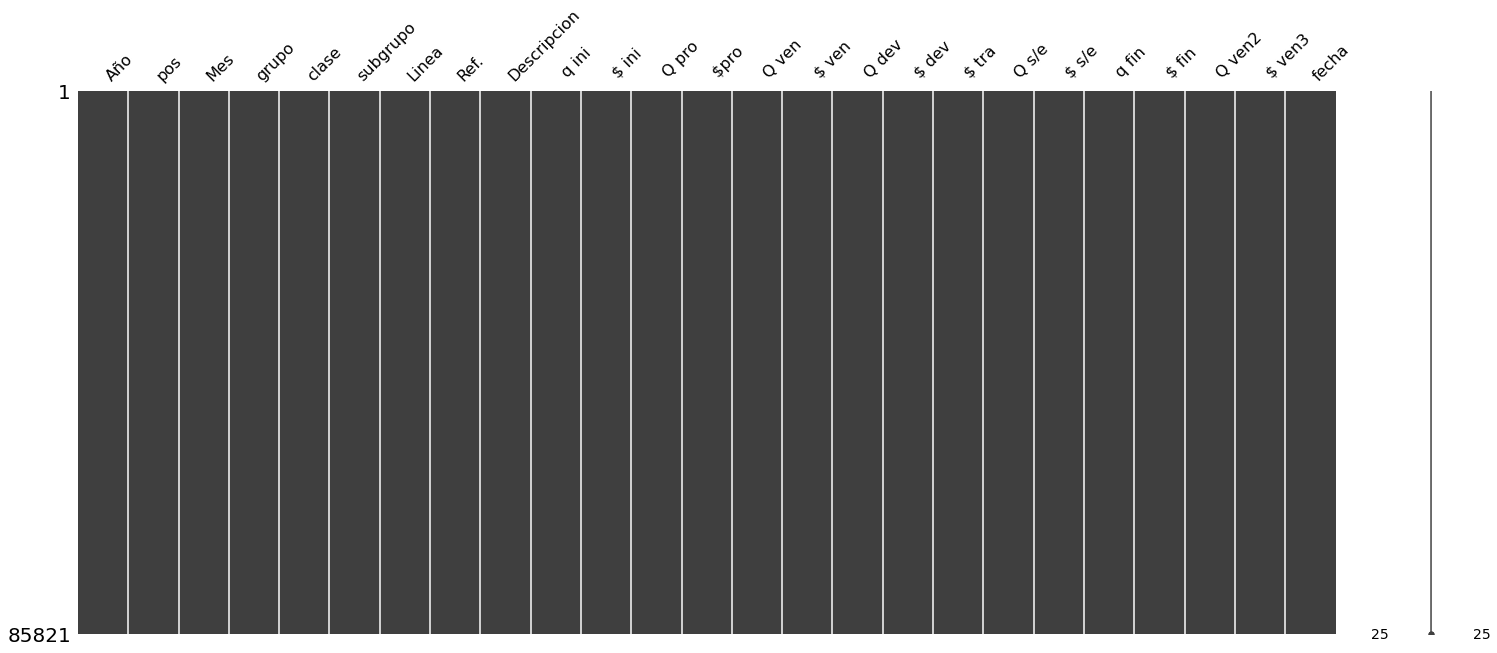

In [ ]:
import missingno as msno
%matplotlib inline
msno.matrix(df)

## Investigacion profunda columnas Cuantitativas

### Variables numericas 

In [ ]:
pd.options.display.max_columns = 10
print("mensual: \n{}".format(df.select_dtypes(include=['float64', 'int']).describe()))

mensual: 
               Año           pos         grupo         q ini         $ ini  \
count  85821.00000  85821.000000  85821.000000  85821.000000  8.582100e+04   
mean    2019.81536      5.934014    190.837196    292.513837  4.973147e+06   
std        0.73565      3.479385    166.032289   1374.932447  1.552986e+07   
min     2019.00000      1.000000    120.000000      0.000000  0.000000e+00   
25%     2019.00000      3.000000    120.000000      6.000000  1.153550e+05   
50%     2020.00000      5.000000    120.000000     30.000000  6.637890e+05   
75%     2020.00000      9.000000    225.000000    184.000000  3.868017e+06   
max     2021.00000     12.000000   5011.000000  96776.000000  4.440176e+08   

       ...         $ s/e         q fin         $ fin        Q ven2  \
count  ...  8.582100e+04  85821.000000  8.582100e+04  85821.000000   
mean   ... -3.147144e+04    292.392025  4.957204e+06     76.413687   
std    ...  1.037279e+06   1384.806616  1.545427e+07   1163.450982   
min    

In [ ]:
import seaborn as sns

Correlacion mensual:
    variable_1 variable_2         r     abs_r
142      Q ven     Q ven2  0.998651  0.998651
295     Q ven2      Q ven  0.998651  0.998651
161      $ ven     $ ven3  0.995247  0.995247
314     $ ven3      $ ven  0.995247  0.995247
274      $ fin      $ ini  0.944043  0.944043


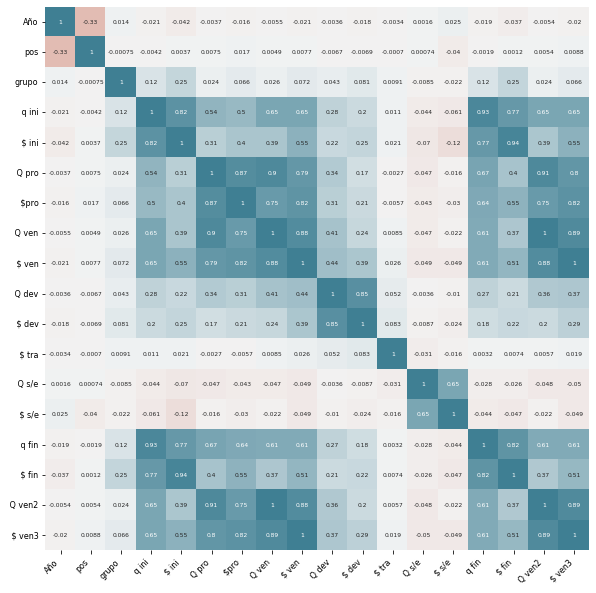

In [ ]:
print("Correlacion mensual:") 
corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
print(tidy_corr_matrix(corr_matrix).head())

# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

#<COMENTARIO>---Eliminacionde las columnas con alta correlacion con respecta a pares
#filtred_mensual = filtred_mensual.drop('ventas_pesos', axis=1)

### Variable respuesta

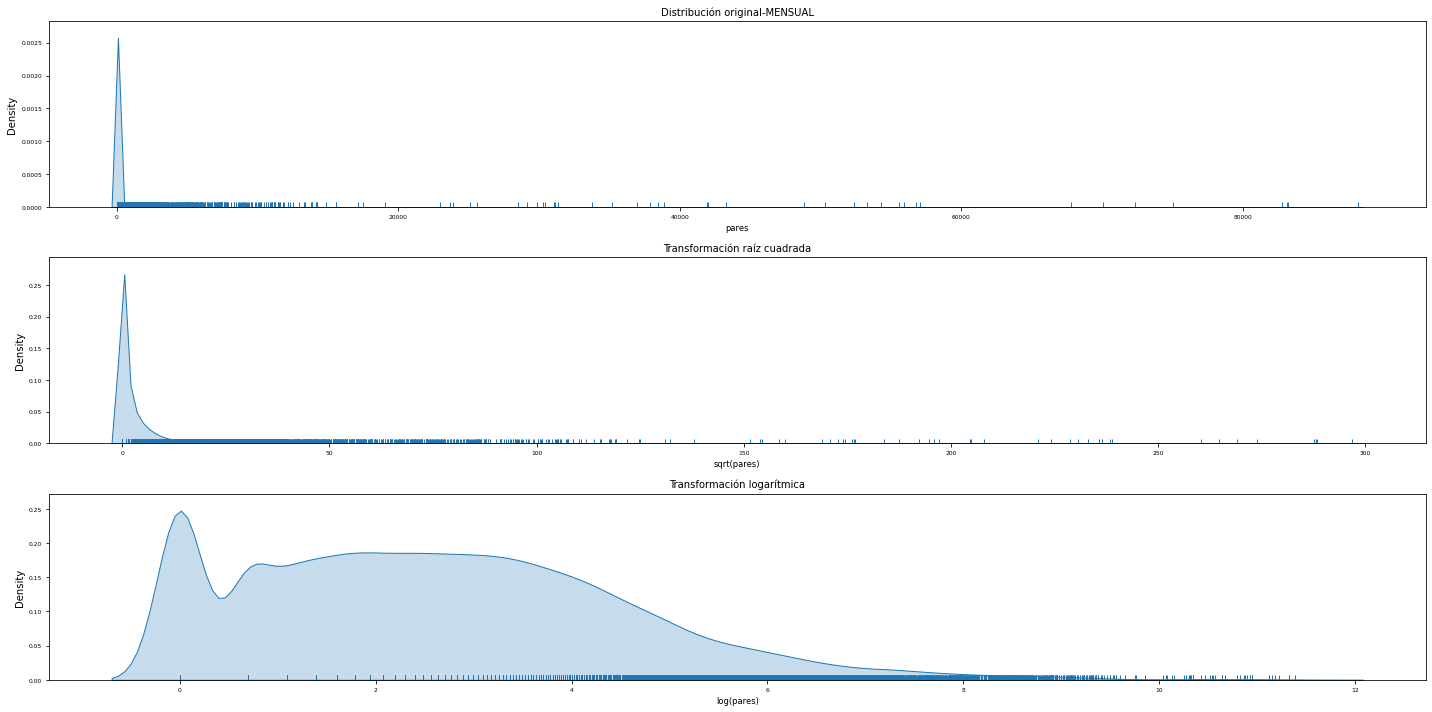

In [ ]:
graficarDistribuciones(df, target)

In [ ]:
%%capture
!pip install fitter

In [ ]:
from fitter import Fitter
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(df[target], distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)
# APARECE EN ORDEN DE LA QUE MAS SE ASEMEJA A LA QUE MENOS

,sumsquare_error,aic,bic,kl_div
chi2,4.994839e-07,6.089293e+03,-2.220130e+06,inf
exponpow,6.065430e-07,1.470223e+04,-2.203464e+06,inf
norm,6.709737e-07,1.926054e+05,-2.194811e+06,inf
powerlaw,9.682913e-07,2.497438e+03,-2.163320e+06,inf
expon,1.167417e-06,1.162773e+05,-2.147282e+06,inf
logistic,1.186253e-06,1.270298e+05,-2.145908e+06,inf
beta,1.252744e-06,1.380340e+05,-2.141205e+06,inf
cauchy,1.257280e-06,1.226593e+04,-2.140918e+06,inf
gamma,1.257280e-06,5.649281e+06,-2.140906e+06,0.011261


## Investigación profunda de columnas categóricas (no numéricas)

---

Nuestro objetivo aquí es terminar con un conjunto de datos que esté listo para el aprendizaje automático, lo que significa que no contiene valores perdidos y que todos los valores en las columnas son numéricos (tipo de datos flotante o int).


In [ ]:
cambioTipo(df, ["grupo", "Año", "pos" ], object)

,Año,pos,Mes,grupo,clase,...,q fin,$ fin,Q ven2,$ ven3,fecha
827,2019,1,1,120,LONAS,...,7.0,170387.0,1.0,24341.0,2019-01-01
828,2019,1,1,120,LONAS,...,11.0,267751.0,1.0,24341.0,2019-01-01
829,2019,1,1,120,LONAS,...,12.0,332844.0,1.0,27737.0,2019-01-01
830,2019,1,1,120,LONAS,...,6.0,166422.0,2.0,55474.0,2019-01-01
831,2019,1,1,120,LONAS,...,27.0,1004670.0,2.0,74420.0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...
398099,2021,5,5,703,PEGADO EN FRIO,...,1229.0,21899551.0,0.0,0.0,2021-05-01
398100,2021,5,5,703,PEGADO EN FRIO,...,21581.0,358719382.0,195.0,3241290.0,2021-05-01
398101,2021,5,5,703,PEGADO EN FRIO,...,12109.0,215770271.0,149.0,2655031.0,2021-05-01
398102,2021,5,5,703,PEGADO EN FRIO,...,7014.0,116586708.0,26.0,432172.0,2021-05-01


In [ ]:
print("Tipo de datos y frecuencias MENSUAL\n{}".format(df.dtypes.value_counts()))

#<COMENATRIO>--- Las variables tipo objeto son textos y deben representarse con un numero
object_columns_mensual = df.select_dtypes(include=['object'])
print("Columnas tipo Objeto MENSUAL: \n", object_columns_mensual.iloc[0])

# Variables cualitativas (tipo object)
# ==============================================================================
df.select_dtypes(include=['object']).describe()

Tipo de datos y frecuencias MENSUAL
float64           15
object             9
datetime64[ns]     1
dtype: int64
Columnas tipo Objeto MENSUAL: 
 Año                             2019
pos                                1
Mes                                1
grupo                            120
clase                          LONAS
subgrupo                360 FLIP MEN
Linea                      Discovery
Ref.                         AF20050
Descripcion    360 FLIP ROJO CROYDON
Name: 827, dtype: object


,Año,pos,Mes,grupo,clase,subgrupo,Linea,Ref.,Descripcion
count,85821,85821,85821,85821,85821,85821,85821,85821,85821
unique,3,12,12,26,4,2301,26,2313,2242
top,2020,3,3,120,LONAS,FEMINELA ESTAMPADA,Discovery,5900090,DISCOVERY ALTO ROJO CROYDON
freq,36451,8974,8974,50673,62252,1288,50673,145,169


Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. En estos casos, suele ser conveniente:

- Eliminar las observaciones del grupo minoritario si es una variable multiclase.
- Eliminar la variable si solo tiene dos niveles.
- Agrupar los niveles minoritarios en un único grupo.
- Asegurar que, en la creación de las particiones, todos los grupos estén representados en cada una de ellas.

Para mayor informacion puede visitar la siguiente pagina: https://www.kaggle.com/code/nextbigwhat/eda-for-categorical-variables-a-beginner-s-way/notebook

In [ ]:
"""fig, axes = plt.subplots(len(object_columns_mensual), 1, figsize=(10,50))
fig.suptitle('Distribución de frecuencia')

for i in range(len(object_columns_mensual)):
    sns.countplot(ax=axes[i], data = df,  x=df[object_columns_mensual[i]])
    axes[i].set_title(object_columns_mensual[i])"""


"fig, axes = plt.subplots(len(object_columns_mensual), 1, figsize=(10,50))\nfig.suptitle('Distribución de frecuencia')\n\nfor i in range(len(object_columns_mensual)):\n    sns.countplot(ax=axes[i], data = df,  x=df[object_columns_mensual[i]])\n    axes[i].set_title(object_columns_mensual[i])"

In [ ]:
print('PRIMER ANALISIS DE SUPERPOSICION subgrupo')
for name in ['subgrupo']:
  print("Valores unicos en la columna: {}\n".format(name))
  print(df[name].value_counts(),'\n')

PRIMER ANALISIS DE SUPERPOSICION subgrupo
Valores unicos en la columna: subgrupo

FEMINELA ESTAMPADA             1288
BOTA TIFFANY ESTAMPADA          939
MACHA ESTAMPADA                 493
MACHITA ESTAMP JR 29-34         351
SONTRA 2018 MEN                 240
                               ... 
TOY ARIF 22-25 GRIS/NARANJA       1
TOY ARIF 26-32 GRIS/NARANJA       1
AYLAN 20-23 FUCSIA/MORADO         1
AYLAN 24-27 FUCSIA/MORADO         1
JAN CAFE MEN                      1
Name: subgrupo, Length: 2301, dtype: int64 



In [ ]:
df = df.groupby(['fecha', 'Descripcion', 'Año', 'Mes'], as_index=False)[target, ' q fin'].sum()

# PRONÓSTICOS SERIES DE TIEMPO (FORECASTING)

Lista de dataframe por referencia 

In [ ]:
# Dataframe by reference
filtred_mensual_fab = df.copy()
reference_list = filtred_mensual_fab['Descripcion'].unique().tolist()
dataframe_list = []
stock_dataframe_list = []

for i in reference_list:
  dataframe = filtred_mensual_fab[filtred_mensual_fab['Descripcion']==i]
  dataframe_list.append(dataframe)
  stock_dataframe_list.append(dataframe)


In [ ]:
data = {'y': [0], 'fecha': ['2021-04-01']}
end_fill_data = pd.DataFrame(data=data)
end_fill_data['fecha'] = pd.to_datetime(end_fill_data['fecha'])
end_fill_data.set_index('fecha', inplace=True)

Agrupar y sumar las ventas por fecha, renombrar la columna objetivo, ordenar el índice y reemplazar los valores perdidos por cero


In [ ]:
from datetime import datetime

last_date = datetime(2021,4,1)
last_date = np.datetime64(last_date.isoformat())
for i in range(len(dataframe_list)):
  dataframe_list[i]['fecha'] = pd.to_datetime(dataframe_list[i]['fecha'])
  dataframe_list[i] = dataframe_list[i].loc[:,[target,'fecha']].groupby('fecha').sum()
  dataframe_list[i] = dataframe_list[i].rename(columns={target: 'y'})
  if not last_date in dataframe_list[i].index.values:
    dataframe_list[i] = pd.concat([dataframe_list[i], end_fill_data])
  #dataframe_list[i] = dataframe_list[i].drop_duplicates(keep=False)
  dataframe_list[i] = dataframe_list[i].asfreq(freq='MS')
  dataframe_list[i] = dataframe_list[i].sort_index()
  dataframe_list[i] = dataframe_list[i].fillna(0)
  try:
    dataframe_list[i] = dataframe_list[i].drop(['2021-05-01'], axis=0)
  except KeyError:
    pass


Inventario final

In [ ]:
last_date = datetime(2021,4,1)
last_date = np.datetime64(last_date.isoformat())
last_date2 = datetime(2021,5,1)
last_date2 = np.datetime64(last_date2.isoformat())
for i in range(len(stock_dataframe_list)):
  stock_dataframe_list[i]['fecha'] = pd.to_datetime(stock_dataframe_list[i]['fecha'], format='%Y/%m/%d')
  stock_dataframe_list[i] = stock_dataframe_list[i].loc[:,['fecha',' q fin']].groupby('fecha').sum()
  stock_dataframe_list[i] = stock_dataframe_list[i].rename(columns={' q fin':'final_inventory'})
  if not last_date in stock_dataframe_list[i].index.values:
    stock_dataframe_list[i] = pd.concat([stock_dataframe_list[i], end_fill_data])
  stock_dataframe_list[i] = stock_dataframe_list[i].asfreq(freq='MS')
  stock_dataframe_list[i] = stock_dataframe_list[i].sort_index()
  stock_dataframe_list[i] = stock_dataframe_list[i].fillna(0)
  if last_date2 in stock_dataframe_list[i].index.values:
    stock_dataframe_list[i] = stock_dataframe_list[i].drop(['2021-05-01'], axis=0)

In [ ]:
stock_data = pd.DataFrame()
final_inventory = []
for i in range(len(stock_dataframe_list)):
  dataframe = stock_dataframe_list[i]
  reference = reference_list[i]
  stock_data["reference"] = reference
  final_inventory.append(dataframe.loc[dataframe.index[-1], "final_inventory"])

stock_data["reference"] = reference_list
stock_data["final_inventory"] = final_inventory

In [ ]:
stock_data.to_csv('stock_data.csv')

## FORECASTING

### Autocorrelation graphic 

### Exponential smoothing Model


In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

errors = []
scores = []
references = []
forecastings = []
index = 0
alpha = 0.5
alpha_forecasting = f'Alpha forecasting= {alpha}'
smoothing_dataframe_list = dataframe_list.copy()
for dataframe in smoothing_dataframe_list:
  if dataframe.shape[0] > 25:
    #fig,ax=plt.subplots()
    #dataframe.plot(y='y', ax=ax, style=':')
    dataframe_array = dataframe.to_numpy()
    model = SimpleExpSmoothing(dataframe_array).fit(smoothing_level=alpha,optimized=False)
    error = mean_squared_error(dataframe['y'], model.fittedvalues, squared=False)
    score = r2_score(dataframe['y'], model.fittedvalues)
    #dataframe.plot(y=alpha_forecasting, ax=ax)
    references.append(reference_list[index])
    errors.append(error)
    scores.append(score)
    forecastings.append(model.forecast(months))
  index+=1

In [ ]:
smoothing_model_results = list(zip(references, forecastings, errors,scores))
smoothing_model_results = pd.DataFrame(smoothing_model_results)
smoothing_model_results.columns = ['reference', 'forecasting_exponential_smoothing', 'error_exponential_smoothing','score_exponential_smoothing']

In [ ]:
smoothing_model_results

,reference,forecasting_exponential_smoothing,error_exponential_smoothing,score_exponential_smoothing
0,360 FLIP ROJO CROYDON,"[4.246830940246582e-07, 4.246830940246582e-07,...",0.582482,0.155556
1,360 FLIP VERDE CROYDON,"[1.914799213409424e-06, 1.914799213409424e-06,...",0.487187,-0.420483
2,4 X 4 AZUL OSCURO AMARILLO,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
4,50-50 GRIS CROYDON,"[1.9669532775878906e-06, 1.9669532775878906e-0...",0.486423,-0.084795
...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[3.1293862760066986, 3.1293862760066986, 3.129...",57.022082,0.146415
1559,TIFFANY FLORESTA AGUAMARINA,"[0.033568769693374634, 0.033568769693374634, 0...",65.095057,0.608071
1560,TIFFANY ROMANTIC MULTICOLOR,"[79.91516724228859, 79.91516724228859, 79.9151...",75.661092,0.073159
1561,WORKMAN RUBBER FIREMEN NEGRO,"[0.34442418813705444, 0.34442418813705444, 0.3...",44.490970,-0.430234


In [ ]:
smoothing_model_results['error_exponential_smoothing'].describe()

count     1563.000000
mean        88.549689
std        661.858343
min          0.000000
25%          0.218218
50%          3.885222
75%         26.849746
max      20386.359177
Name: error_exponential_smoothing, dtype: float64

In [ ]:
smoothing_model_results['score_exponential_smoothing'].describe()

count    1563.000000
mean        0.226945
std         0.514514
min        -0.656188
25%        -0.212796
50%         0.106870
75%         0.687872
max         1.000000
Name: score_exponential_smoothing, dtype: float64

### HOLT-Winter Model

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing

winters_dataframe = dataframe_list.copy()
errors = []
scores = []
references = []
forecastings = []
index = 0
for dataframe in winters_dataframe:
  if dataframe.shape[0] > 25:
    model = ExponentialSmoothing(dataframe['y'], seasonal_periods=12, trend='add', seasonal='add').fit(optimized=1)
    forecast = model.forecast(months).values
    error = mean_squared_error(dataframe['y'], model.fittedvalues, squared=False)
    score =r2_score(dataframe['y'], model.fittedvalues)
    references.append(reference_list[index])
    errors.append(error)
    scores.append(score)
    forecastings.append(forecast)
  index += 1

In [ ]:
winters_model_results = list(zip(references, forecastings, errors,scores))
winters_model_results = pd.DataFrame(winters_model_results)
winters_model_results.columns = ['reference', 'forecasting_holt_winter', 'error_holt_winter','score_holt_winter']

In [ ]:
winters_model_results

,reference,forecasting_holt_winter,error_holt_winter,score_holt_winter
0,360 FLIP ROJO CROYDON,"[0.8938022634182963, 1.1694858046463446, 0.488...",0.642909,-0.028739
1,360 FLIP VERDE CROYDON,"[-0.11228938338183198, -0.11774339471498318, -...",0.419774,-0.054573
2,4 X 4 AZUL OSCURO AMARILLO,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
4,50-50 GRIS CROYDON,"[-0.0881032065264119, -0.09756332732480871, -0...",0.482710,-0.068296
...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[-3.7783080943084277, 28.91766977287985, 3.747...",67.385927,-0.192063
1559,TIFFANY FLORESTA AGUAMARINA,"[-19.699106450932447, -130.39893329027853, -22...",82.612778,0.368743
1560,TIFFANY ROMANTIC MULTICOLOR,"[200.73190812704672, 183.62947165357951, 128.0...",87.470303,-0.238744
1561,WORKMAN RUBBER FIREMEN NEGRO,"[-51.797912106638364, -65.28562115001603, -78....",32.133124,0.253948


In [ ]:
winters_model_results['error_holt_winter'].describe()

count     1563.000000
mean        69.388273
std        534.246391
min          0.000000
25%          0.190642
50%          3.537390
75%         25.396016
max      17207.703673
Name: error_holt_winter, dtype: float64

In [ ]:
winters_model_results['score_holt_winter'].describe()

count    1563.000000
mean        0.339963
std         0.450467
min        -0.597024
25%        -0.068130
50%         0.202505
75%         0.783112
max         1.000000
Name: score_holt_winter, dtype: float64

### Autoregression Model

In [ ]:
from statsmodels.tsa.ar_model import AR
forecastings = []
errors = []
scores = []
training_percents = []
references = []
percents = [0.04,0.08,0.12,0.16,0.2,0.24,0.27,0.31,0.35,0.39,0.43,0.47]
index = 0
ar_dataframe_list = dataframe_list.copy()
for dataframe in ar_dataframe_list:
  rows = dataframe.shape[0]
  if rows > 25:
    min_error = 99999999999999999999999999999999999
    training_percent = 0
    best_forecasting = None
    for percent in percents:
      data_length = rows - int(rows * percent)
      dataframe['t'] = dataframe['y'].shift(1)
      train = dataframe[1:data_length]
      test = dataframe[data_length:]
      train_x, train_y = train['t'], train['y']
      test_x, test_y = test['t'],test['y']
      train = dataframe.y[1:data_length]
      test = dataframe.y[data_length:]
      modelAR = AR(train)
      model = modelAR.fit()
      end_predict = len(train) + len(test)
      forecasting =  model.predict(start=len(train), end=end_predict - 1)
      error = mean_squared_error(test_y, forecasting, squared=False)
      score = r2_score(test_y, forecasting)
      forecasting =  model.predict(start=len(train), end=end_predict + (months - 1))
      if error < min_error:
        min_error = error
        training_percent = percent
        best_forecasting = forecasting.values[-4:]
    errors.append(min_error)
    scores.append(score)
    training_percents.append(training_percent)
    forecastings.append(best_forecasting)
    references.append(reference_list[index])
  index+=1

In [ ]:
ar_model_results = list(zip(references, forecastings, errors, scores))
ar_model_results = pd.DataFrame(ar_model_results)
ar_model_results.columns = ['reference', 'forecasting_autoregression', 'error_autoregression','score_autoregression']

In [ ]:
ar_model_results

,reference,forecasting_autoregression,error_autoregression,score_autoregression
0,360 FLIP ROJO CROYDON,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
1,360 FLIP VERDE CROYDON,"[0.0, 0.0, 0.0, 0.0]",0.000000,0.000000
2,4 X 4 AZUL OSCURO AMARILLO,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
4,50-50 GRIS CROYDON,"[0.0, 0.0, 0.0, 0.0]",0.000000,0.000000
...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[-0.08715323977121736, -3.0284037546500957, 2....",6.048272,-334965.196913
1559,TIFFANY FLORESTA AGUAMARINA,"[-2.069989232551554, -2.8560937615798676, -2.7...",2.258276,-0.859990
1560,TIFFANY ROMANTIC MULTICOLOR,"[1.8185294998369912, 1.9649691525039508, 11.72...",91.370551,-16295.205599
1561,WORKMAN RUBBER FIREMEN NEGRO,"[38.51921852824659, 22.554476075105928, 34.234...",14.948713,-98762.415757


In [ ]:
ar_model_results['error_autoregression'].describe()

count    1563.000000
mean       43.171769
std       312.787455
min         0.000000
25%         0.000000
50%         0.133893
75%         3.482429
max      6502.573722
Name: error_autoregression, dtype: float64

In [ ]:
ar_model_results['score_autoregression'].describe()

count    1.563000e+03
mean    -4.400303e+79
std      1.739651e+81
min     -6.877673e+82
25%     -7.594494e+03
50%     -1.275510e-01
75%      1.000000e+00
max      1.000000e+00
Name: score_autoregression, dtype: float64

### Moving average model

In [ ]:
forecastings = []
errors = []
scores = []
percents = [0.04,0.08,0.12,0.16,0.2,0.24,0.27,0.31,0.35,0.39,0.43,0.47]
references = []
index = 0
moving_average_dataframe_list = deepcopy(dataframe_list)
for dataframe in moving_average_dataframe_list:
   rows = dataframe.shape[0]
   if rows > 25:
    min_error = 99999999999999999999999999999999999999
    best_forecasting = None
    for percent in percents:
      dataframe['t'] = dataframe['y'].shift(1)
      data_length = rows - int(rows * percent)
      train = dataframe[1:data_length]
      test = dataframe[data_length:]
      train_x, train_y = train['t'], train['y']
      test_x, test_y = test['t'],test['y']
      dataframe['resid'] = dataframe['y'] - dataframe['t']
      train = dataframe.resid[1:data_length]
      test = dataframe.resid[data_length:]
      try:
        modelAR = AR(train)
        model = modelAR.fit()
        resid_pred = model.predict(start=len(train), end=len(train)+len(test)-1)
        forecasting = dataframe.t[data_length:] + resid_pred
        error = mean_squared_error(test_y, forecasting, squared=False)
        score = r2_score(test_y, forecasting)
        if error < min_error:
          min_error = error
          best_forecasting = forecasting.values[-months:]
      except:
        print(f"Error in {reference_list[index]} with percent: {percent}")
    forecastings.append(best_forecasting)
    errors.append(error)
    scores.append(score)
    references.append(reference_list[index])
    index += 1

In [ ]:
moving_average_results = list(zip(references, forecastings, errors,scores))
moving_average_results = pd.DataFrame(moving_average_results)
moving_average_results.columns = ['reference', 'forecasting_moving_average', 'error_moving_average','score_moving_average']

In [ ]:
moving_average_results

,reference,forecasting_moving_average,error_moving_average,score_moving_average
0,360 FLIP ROJO CROYDON,[0.0],0.000000,1.000000
1,360 FLIP VERDE CROYDON,[0.0],12.403745,0.000000
2,4 X 4 AZUL OSCURO AMARILLO,[0.0],0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,[0.0],0.000000,1.000000
4,50-50 GRIS CROYDON,[-0.008333333333333314],0.585996,0.000000
...,...,...,...,...
1558,TELGA ROSADO CROYDON,[-3.3359084743714718],259.246375,-1611.202285
1559,TIFFANY FLORESTA AGUAMARINA,[-0.5639031973065003],133.637638,-143.639968
1560,TIFFANY ROMANTIC MULTICOLOR,"[-3.2875395132703114, -12.094589841275733, 211...",78.393724,-0.423880
1561,WORKMAN RUBBER FIREMEN NEGRO,[-13.691957928289089],12152.831820,-153114.215077


In [ ]:
moving_average_results['error_moving_average'].describe()

count    1.563000e+03
mean     7.573084e+31
std      2.994003e+33
min      0.000000e+00
25%      0.000000e+00
50%      6.224501e+00
75%      9.046302e+02
max      1.183673e+35
Name: error_moving_average, dtype: float64

In [ ]:
moving_average_results['score_moving_average'].describe()

count    1.563000e+03
mean    -5.370399e+62
std      2.123176e+64
min     -8.393934e+65
25%     -8.087983e+03
50%     -1.166667e+00
75%      1.000000e+00
max      1.000000e+00
Name: score_moving_average, dtype: float64

### ARIMA Model

In [ ]:
arima_dataframe = deepcopy(dataframe_list)
predictions = []
references = []
errors =[]
scores = []
i=0
for dataframe in arima_dataframe:
  if dataframe.shape[0]>25:
    try:
      p_d_q = [3, 0, 0]
      modelARIMA = ARIMA(dataframe['y'], order = p_d_q)
      model_fit = modelARIMA.fit()
    except ValueError:
      p_d_q = [2, 0, 0]
      modelARIMA = ARIMA(dataframe['y'], order = p_d_q)
      model_fit = modelARIMA.fit()
    except LinAlgError:
      p_d_q = [0, 0, 0]
      modelARIMA = ARIMA(dataframe['y'], order = p_d_q)
      model_fit = modelARIMA.fit()
    finally:
      prediction=model_fit.forecast(months)[0]
      references.append(reference_list[i])
      predictions.append(prediction)
      errors.append(mean_squared_error(dataframe['y'], model_fit.predict().values, squared=False))
      scores.append(r2_score(dataframe['y'], model_fit.predict().values))
  i+=1

In [ ]:
arima_model_results = list(zip(references, predictions, errors,scores))
arima_model_results = pd.DataFrame(arima_model_results)
arima_model_results.columns = ['reference', 'forecasting_arima', 'error_arima','score_arima']

In [ ]:
arima_model_results

,reference,forecasting_arima,error_arima,score_arima
0,360 FLIP ROJO CROYDON,"[0.13714626244153882, 0.23741065296750602, 0.2...",0.506475,0.361558
1,360 FLIP VERDE CROYDON,"[0.12329542923041446, 0.11565453096122821, 0.1...",0.407038,0.008448
2,4 X 4 AZUL OSCURO AMARILLO,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000
4,50-50 GRIS CROYDON,"[0.07114226111959374, 0.07363721379462064, 0.0...",0.464000,0.012912
...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[23.349477207652647, 32.18163359353992, 37.211...",54.598546,0.217431
1559,TIFFANY FLORESTA AGUAMARINA,"[12.455915215545266, 24.194142308299917, 30.45...",59.545386,0.672050
1560,TIFFANY ROMANTIC MULTICOLOR,"[135.2940331841328, 145.11591771503956, 73.640...",65.127331,0.313269
1561,WORKMAN RUBBER FIREMEN NEGRO,"[18.98969694636262, 16.226990470716707, 19.139...",35.824992,0.072667


In [ ]:
arima_model_results['error_arima'].describe()

count     1563.000000
mean        74.777068
std        545.236594
min          0.000000
25%          0.185097
50%          3.529989
75%         24.670123
max      17024.085503
Name: error_arima, dtype: float64

In [ ]:
arima_model_results['score_arima'].describe()

count    1563.000000
mean        0.392428
std         0.394201
min        -1.402352
25%         0.059220
50%         0.259088
75%         0.737557
max         1.000000
Name: score_arima, dtype: float64

### SARIMAX Model

In [ ]:
predictions = []
errors = []
scores=[]
references = []
i = 0
sarimax_dataframe_list = deepcopy(dataframe_list)
for dataframe in sarimax_dataframe_list:
  if dataframe.shape[0]>25:
    try:
      modelSARIMAX = SARIMAX(dataframe['y'], order=(6,0,3), seasonal_order=(1,0,0,12))
      model_fit = modelSARIMAX.fit()
    except LinAlgError:
      modelSARIMAX = SARIMAX(dataframe['y'], order=(0,0,0), seasonal_order=(0,0,0,12))
      model_fit = modelSARIMAX.fit()

    prediction = model_fit.forecast(months).values
    predictions.append(prediction)
    references.append(reference_list[i])
    predictions.append(prediction)
    errors.append(mean_squared_error(dataframe['y'], model_fit.predict().values, squared=False))
    scores.append(r2_score(dataframe['y'], model_fit.predict().values))
  i += 1


In [ ]:
sarimax_model_results = list(zip(references, predictions, errors, scores))
sarimax_model_results = pd.DataFrame(sarimax_model_results)
sarimax_model_results.columns = ['reference', 'forecasting_sarimax', 'error_sarimax','score_sarimax']

In [ ]:
sarimax_model_results

,reference,forecasting_sarimax,error_sarimax,score_sarimax
0,360 FLIP ROJO CROYDON,"[0.05751290997980447, 0.029876169313541208, 0....",0.498811,0.380733
1,360 FLIP VERDE CROYDON,"[0.05751290997980447, 0.029876169313541208, 0....",0.422577,-0.068702
2,4 X 4 AZUL OSCURO AMARILLO,"[-9.217760993642131e-17, -3.270049736462329e-1...",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[-9.217760993642131e-17, -3.270049736462329e-1...",0.000000,1.000000
4,50-50 GRIS CROYDON,"[0.0, 0.0, 0.0, 0.0]",0.489816,-0.099985
...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[0.01790827800843378, -0.0071233734379080975, ...",54.463213,0.221305
1559,TIFFANY FLORESTA AGUAMARINA,"[0.01790827800843378, -0.0071233734379080975, ...",88.943665,0.268285
1560,TIFFANY ROMANTIC MULTICOLOR,"[-1.2272350415138708e-12, -6.017881158173194e-...",63.792122,0.341138
1561,WORKMAN RUBBER FIREMEN NEGRO,"[-1.2272350415138708e-12, -6.017881158173194e-...",32.091017,0.255902


In [ ]:
sarimax_model_results['error_sarimax'].describe()

count     1563.000000
mean        77.936364
std        553.120979
min          0.000000
25%          0.188982
50%          3.624363
75%         25.003606
max      17396.133667
Name: error_sarimax, dtype: float64

In [ ]:
sarimax_model_results['score_sarimax'].describe()

count    1563.000000
mean        0.341412
std         0.463776
min        -2.734543
25%         0.017254
50%         0.248478
75%         0.682193
max         1.000000
Name: score_sarimax, dtype: float64

## Análisis de resultados

###Tabla resumen de pronósticos series de tiempo

In [ ]:
times_series_dataframe = pd.merge(smoothing_model_results,winters_model_results, on='reference')
times_series_dataframe = pd.merge(times_series_dataframe,ar_model_results, on='reference')
times_series_dataframe = pd.merge(times_series_dataframe,moving_average_results, on='reference')
times_series_dataframe = pd.merge(times_series_dataframe,arima_model_results, on='reference')
times_series_dataframe = pd.merge(times_series_dataframe,sarimax_model_results, on='reference')
times_series_dataframe

,reference,forecasting_exponential_smoothing,error_exponential_smoothing,score_exponential_smoothing,forecasting_holt_winter,...,error_arima,score_arima,forecasting_sarimax,error_sarimax,score_sarimax
0,360 FLIP ROJO CROYDON,"[4.246830940246582e-07, 4.246830940246582e-07,...",0.582482,0.155556,"[0.8938022634182963, 1.1694858046463446, 0.488...",...,0.506475,0.361558,"[0.05751290997980447, 0.029876169313541208, 0....",0.498811,0.380733
1,360 FLIP VERDE CROYDON,"[1.914799213409424e-06, 1.914799213409424e-06,...",0.487187,-0.420483,"[-0.11228938338183198, -0.11774339471498318, -...",...,0.407038,0.008448,"[0.05751290997980447, 0.029876169313541208, 0....",0.422577,-0.068702
2,4 X 4 AZUL OSCURO AMARILLO,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000,"[0.0, 0.0, 0.0, 0.0]",...,0.000000,1.000000,"[-9.217760993642131e-17, -3.270049736462329e-1...",0.000000,1.000000
3,4 X 4 NEGRO VERDE LOS GOMOSOS,"[0.0, 0.0, 0.0, 0.0]",0.000000,1.000000,"[0.0, 0.0, 0.0, 0.0]",...,0.000000,1.000000,"[-9.217760993642131e-17, -3.270049736462329e-1...",0.000000,1.000000
4,50-50 GRIS CROYDON,"[1.9669532775878906e-06, 1.9669532775878906e-0...",0.486423,-0.084795,"[-0.0881032065264119, -0.09756332732480871, -0...",...,0.464000,0.012912,"[0.0, 0.0, 0.0, 0.0]",0.489816,-0.099985
...,...,...,...,...,...,...,...,...,...,...,...
1558,TELGA ROSADO CROYDON,"[3.1293862760066986, 3.1293862760066986, 3.129...",57.022082,0.146415,"[-3.7783080943084277, 28.91766977287985, 3.747...",...,54.598546,0.217431,"[0.01790827800843378, -0.0071233734379080975, ...",54.463213,0.221305
1559,TIFFANY FLORESTA AGUAMARINA,"[0.033568769693374634, 0.033568769693374634, 0...",65.095057,0.608071,"[-19.699106450932447, -130.39893329027853, -22...",...,59.545386,0.672050,"[0.01790827800843378, -0.0071233734379080975, ...",88.943665,0.268285
1560,TIFFANY ROMANTIC MULTICOLOR,"[79.91516724228859, 79.91516724228859, 79.9151...",75.661092,0.073159,"[200.73190812704672, 183.62947165357951, 128.0...",...,65.127331,0.313269,"[-1.2272350415138708e-12, -6.017881158173194e-...",63.792122,0.341138
1561,WORKMAN RUBBER FIREMEN NEGRO,"[0.34442418813705444, 0.34442418813705444, 0.3...",44.490970,-0.430234,"[-51.797912106638364, -65.28562115001603, -78....",...,35.824992,0.072667,"[-1.2272350415138708e-12, -6.017881158173194e-...",32.091017,0.255902


###Diagrama de cajas r^2

In [ ]:
df1 = times_series_dataframe.loc[:,['score_exponential_smoothing','score_holt_winter', 'score_autoregression', 'score_moving_average','score_arima','score_sarimax']]
df1 = df1.melt(var_name='MethodsResult', value_name='Value')
df1['value_num'] = df1['Value'].apply(pd.to_numeric, errors='coerce')

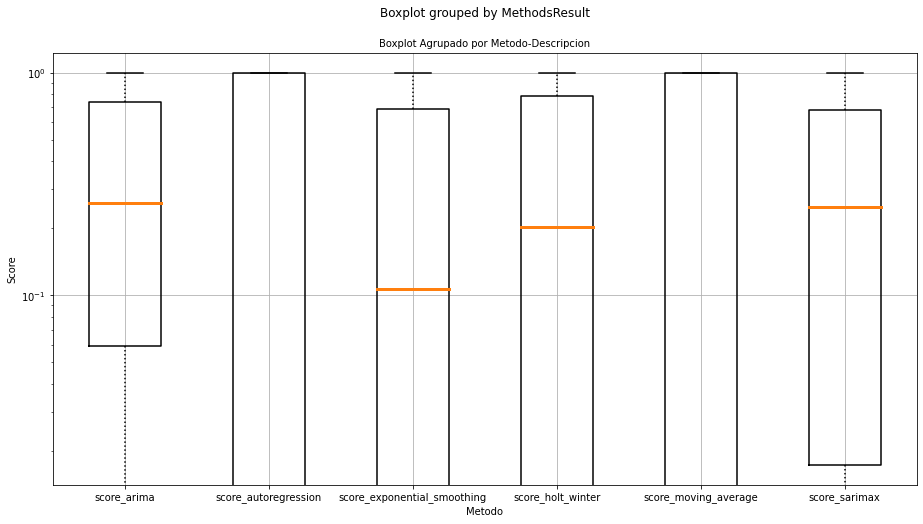

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), sharey=True)

grafica = df1.boxplot(by ='MethodsResult', column ='value_num', ax=axes, grid=True,  showfliers=False, 
                color=dict(boxes='r',  whiskers='r', medians='r', caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='solid', linewidth=3),
                whiskerprops=dict(linestyle='dotted', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                rot=0)

grafica.set_title("Boxplot Agrupado por Metodo-Descripcion", fontsize=10)
grafica.set_xlabel('Metodo')
grafica.set_ylabel('Score')
grafica.set_yscale('log')

###Diagrama de cajas rmse

In [ ]:
df2 = times_series_dataframe.loc[:,['error_exponential_smoothing','error_holt_winter', 'error_autoregression', 'error_moving_average','error_arima','error_sarimax']]
df2 = df2.melt(var_name='MethodsResult', value_name='Value')
df2['value_num'] = df2['Value'].apply(pd.to_numeric, errors='coerce')

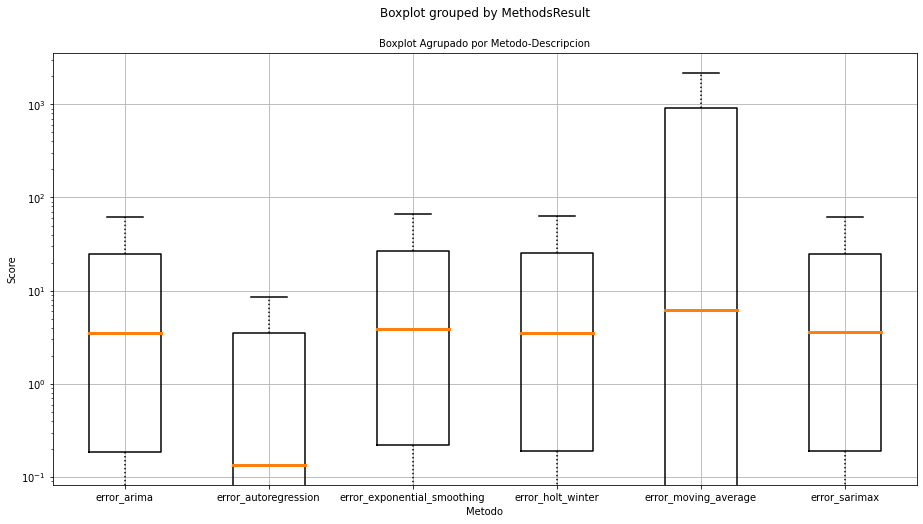

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 8), sharey=True)

grafica = df2.boxplot(by ='MethodsResult', column ='value_num', ax=axes, grid=True,  showfliers=False, 
                color=dict(boxes='r',  whiskers='r', medians='r', caps='r'),
                boxprops=dict(linestyle='-', linewidth=1.5),
                flierprops=dict(linestyle='-', linewidth=1.5),
                medianprops=dict(linestyle='solid', linewidth=3),
                whiskerprops=dict(linestyle='dotted', linewidth=1.5),
                capprops=dict(linestyle='-', linewidth=1.5),
                rot=0)

grafica.set_title("Boxplot Agrupado por Metodo-Descripcion", fontsize=10)
grafica.set_xlabel('Metodo')
grafica.set_ylabel('Score')
grafica.set_yscale('log')

###Selección modelo series de tiempo por referencia (rmse)

In [ ]:
## Se retiran los datos obtenidos para los modelos de suavización exponencial y promedios moviles dado que solo pronósticas un mes. 
##min_values = times_series_dataframe[['error_holt_winter', 'error_autoregression','error_arima','error_sarimax']].min(axis=1)
##model_names = times_series_dataframe[['error_holt_winter', 'error_autoregression','error_arima','error_sarimax']].idxmin(axis=1)
min_values = times_series_dataframe[['error_exponential_smoothing','error_holt_winter', 'error_autoregression', 'error_moving_average','error_arima','error_sarimax']].min(axis=1)
model_names = times_series_dataframe[['error_exponential_smoothing','error_holt_winter', 'error_autoregression', 'error_moving_average','error_arima','error_sarimax']].idxmin(axis=1)
times_series_rmse_data = pd.merge(times_series_dataframe['reference'], min_values.rename('times_series_rmse'), left_index=True, right_index=True)
times_series_rmse_data = pd.merge(times_series_rmse_data, model_names.rename('times_series_model'), left_index=True, right_index=True)

forecastings = []
model_names = []

for index in range(len(times_series_rmse_data)):
  model_name = times_series_rmse_data.iloc[index]['times_series_model']
  model_name = model_name[model_name.index('_')+1:]
  column_name = 'forecasting_'+ model_name
  forecastings.append(np.clip(times_series_dataframe.iloc[index][column_name], 0, float('inf')))
  model_names.append(model_name)

times_series_rmse_data['times_series_forecastings'] = forecastings
times_series_rmse_data['times_series_model'] = model_names
times_series_rmse_data

,reference,times_series_rmse,times_series_model,times_series_forecastings
0,360 FLIP ROJO CROYDON,0.000000,autoregression,"[0.0, 0.0, 0.0, 0.0]"
1,360 FLIP VERDE CROYDON,0.000000,autoregression,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 AZUL OSCURO AMARILLO,0.000000,exponential_smoothing,"[0.0, 0.0, 0.0, 0.0]"
3,4 X 4 NEGRO VERDE LOS GOMOSOS,0.000000,exponential_smoothing,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS CROYDON,0.000000,autoregression,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
1558,TELGA ROSADO CROYDON,6.048272,autoregression,"[0.0, 0.0, 2.044400887099669, 3.112732316798483]"
1559,TIFFANY FLORESTA AGUAMARINA,2.258276,autoregression,"[0.0, 0.0, 0.0, 0.0]"
1560,TIFFANY ROMANTIC MULTICOLOR,63.792122,sarimax,"[0.0, 0.0, 0.0, 0.0]"
1561,WORKMAN RUBBER FIREMEN NEGRO,14.948713,autoregression,"[38.51921852824659, 22.554476075105928, 34.234..."


In [ ]:
times_series_rmse_data.to_excel('times_series_rmse_data.xlsx')

In [ ]:
times_series_rmse_data.to_csv('times_series_rmse_data.csv')

In [ ]:
times_series_rmse_freq = times_series_rmse_data['times_series_model'].value_counts() 
times_series_rmse_freq

autoregression           1069
exponential_smoothing     375
holt_winter                49
sarimax                    42
arima                      27
moving_average              1
Name: times_series_model, dtype: int64

###Selección modelo series de tiempo por referencia (r^2)

In [ ]:
#min_score_values = times_series_dataframe[['score_exponential_smoothing','score_holt_winter', 'score_autoregression', 'score_moving_average','score_arima','score_sarimax']].min(axis=1)
model_names = abs(times_series_dataframe[['score_exponential_smoothing','score_holt_winter', 'score_autoregression', 'score_moving_average','score_arima','score_sarimax']]-1).idxmin(axis=1)
#model_names = abs(times_series_dataframe[['score_holt_winter', 'score_autoregression','score_arima','score_sarimax']]-1).idxmin(axis=1)
#times_series_score_data = pd.merge(times_series_dataframe['reference'], min_score_values.rename('times_series_score'), left_index=True, right_index=True)
#times_series_score_data = pd.merge(times_series_score_data, model_names.rename('times_series_model'), left_index=True, right_index=True)
times_series_score_data = pd.merge(times_series_dataframe['reference'], model_names.rename('times_series_model'), left_index=True, right_index=True)

forecastings = []
model_names = []
min_scores = []

for index in range(len(times_series_score_data)):
  model_name = times_series_score_data.iloc[index]['times_series_model']
  min_scores.append(times_series_dataframe.iloc[index][model_name])
  model_name = model_name[model_name.index('_')+1:]
  column_name = 'forecasting_'+ model_name
  forecastings.append(np.clip(times_series_dataframe.iloc[index][column_name], 0, float('inf')))
  model_names.append(model_name)

times_series_score_data['times_series_score'] = min_scores
times_series_score_data['times_series_forecastings'] = forecastings
times_series_score_data['times_series_model'] = model_names
times_series_score_data

,reference,times_series_model,times_series_score,times_series_forecastings
0,360 FLIP ROJO CROYDON,autoregression,1.000000,"[0.0, 0.0, 0.0, 0.0]"
1,360 FLIP VERDE CROYDON,arima,0.008448,"[0.12329542923041446, 0.11565453096122821, 0.1..."
2,4 X 4 AZUL OSCURO AMARILLO,exponential_smoothing,1.000000,"[0.0, 0.0, 0.0, 0.0]"
3,4 X 4 NEGRO VERDE LOS GOMOSOS,exponential_smoothing,1.000000,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS CROYDON,arima,0.012912,"[0.07114226111959374, 0.07363721379462064, 0.0..."
...,...,...,...,...
1558,TELGA ROSADO CROYDON,sarimax,0.221305,"[0.01790827800843378, 0.0, 0.00757239425542207..."
1559,TIFFANY FLORESTA AGUAMARINA,arima,0.672050,"[12.455915215545266, 24.194142308299917, 30.45..."
1560,TIFFANY ROMANTIC MULTICOLOR,sarimax,0.341138,"[0.0, 0.0, 0.0, 0.0]"
1561,WORKMAN RUBBER FIREMEN NEGRO,sarimax,0.255902,"[0.0, 0.0, 0.0, 0.0]"


In [ ]:
times_series_score_data.to_excel('times_series_score_data.xlsx')

In [ ]:
times_series_score_data.to_csv('times_series_score_data.csv')

In [ ]:
times_series_score_freq = times_series_score_data['times_series_model'].value_counts() 
times_series_score_freq

exponential_smoothing    458
arima                    394
holt_winter              318
sarimax                  220
autoregression           171
moving_average             2
Name: times_series_model, dtype: int64

## PRONÓSTICOS METODOS DE REGRESIONES Y CLASIFICACION 


###PREDICCIONES

In [ ]:
dfMensualFeatures = df.copy()
dfMensualFeatures['fecha'] = pd.to_datetime(dfMensualFeatures['fecha'], format="%Y-%m-%d")
dfMensualFeatures.rename(columns={target:'ventas_pares'},inplace=True)
dfMensualFeatures.columns.values

columna = 'Descripcion'
dfMensualFeatures = eliminarFrecuencia(dfMensualFeatures, 28*0.75, columna) # el 75% de los datos (28 meses)

cambioTipo(dfMensualFeatures,['Año', 'Mes',], object )
dfMensualFeatures['fecha'] = pd.to_datetime(dfMensualFeatures['fecha'], format="%Y-%m-%d")
dfMensualFeatures = dfMensualFeatures[dfMensualFeatures['fecha']!='2021-05-01']

agrupacionCol = 'Descripcion'
fecha_maxima = datetime.fromisoformat(str(dfMensualFeatures['fecha'].max()))
frecuencia = "MS"

dfMensualFeatures = completarDataCeros(dfMensualFeatures, agrupacionCol, fecha_maxima, frecuencia)
dfMensualFeatures = prepararMensual(dfMensualFeatures)


In [ ]:
dfMensualFeatures

,fecha,Descripcion,ventas_pares,num_mes,num_año
0,2019-01-01,360 FLIP VERDE CROYDON,1.0,1,2019
1,2019-02-01,360 FLIP VERDE CROYDON,0.0,2,2019
2,2019-03-01,360 FLIP VERDE CROYDON,0.0,3,2019
3,2019-04-01,360 FLIP VERDE CROYDON,0.0,4,2019
4,2019-05-01,360 FLIP VERDE CROYDON,0.0,5,2019
...,...,...,...,...,...
43848,2020-12-01,ZUZANY VINOTINTO CROYDON,3.0,12,2020
43849,2021-01-01,ZUZANY VINOTINTO CROYDON,1.0,1,2021
43850,2021-02-01,ZUZANY VINOTINTO CROYDON,3.0,2,2021
43851,2021-03-01,ZUZANY VINOTINTO CROYDON,6.0,3,2021


**Funciones**

#### BAGGING REGRESOR

In [ ]:
df = dfMensualFeatures
metricaEval = rmse
agrupacionCol = 'Descripcion'

things, score, metricResult = bagingReview(df, agrupacionCol, metricaEval)
ref, prediccion = predictBaggingRegresor(df, agrupacionCol, startDatePredict, endDatePredict)

predict_list = list(zip(ref, score, metricResult, prediccion))
resultPredictBagginRegresor  = pd.DataFrame(predict_list)
resultPredictBagginRegresor = resultPredictBagginRegresor.set_axis(['reference', 'score_baggin_regresor', 'error_baggin_regresor', 'forecasting_baggin_regresor'], axis=1)
resultPredictBagginRegresor 

,reference,score_baggin_regresor,error_baggin_regresor,forecasting_baggin_regresor
0,360 FLIP VERDE CROYDON,-0.346154,0.845154,"[0.8, 0.1, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
3,50-50 GRIS CROYDON,-0.144231,0.779194,"[1.2, 0.5, 0.7, 0.8]"
4,50-50 GRIS OSCURO CROYDON,0.696667,0.192725,"[0.8, 0.3, 0.8, 1.4]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.452136,18.374400,"[59.2, 26.5, 26.7, 22.8]"
1599,ZUZANY AZUL CROYDON,0.439697,7.627582,"[12.8, 9.2, 11.5, 10.9]"
1600,ZUZANY GRIS CROYDON,0.640873,31.898321,"[126.5, 99.7, 60.1, 38.7]"
1601,ZUZANY ROSADO CROYDON,0.203905,74.324876,"[213.3, 145.9, 54.8, 38.6]"


####RANDOM FOREST

In [ ]:
from datetime import datetime

df = dfMensualFeatures
metricaEval = rmse
agrupacionCol = 'Descripcion'

things, score, metricResult = randomReview(df, agrupacionCol, metricaEval)
ref, prediction = preddictRandomForest(df, agrupacionCol, startDatePredict, endDatePredict)

predict_list = list(zip(ref, score, metricResult, prediction))
resultPredictRandomForest  = pd.DataFrame(predict_list)
resultPredictRandomForest = resultPredictRandomForest.set_axis(['reference', 'score_random_forest', 'error_random_forest', 'forecasting_random_forest'], axis=1)
resultPredictRandomForest


,reference,score_random_forest,error_random_forest,forecasting_random_forest
0,360 FLIP VERDE CROYDON,-0.346154,0.845154,"[0.65, 0.18, 0.05, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
3,50-50 GRIS CROYDON,0.006619,0.726017,"[1.37, 0.56, 0.74, 0.86]"
4,50-50 GRIS OSCURO CROYDON,0.684067,0.196687,"[0.8, 0.44, 0.84, 1.58]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.466736,18.127918,"[51.43, 30.97, 27.75, 23.04]"
1599,ZUZANY AZUL CROYDON,0.598568,6.456265,"[12.37, 8.77, 12.39, 11.48]"
1600,ZUZANY GRIS CROYDON,0.470678,38.726090,"[134.98, 99.76, 58.47, 38.35]"
1601,ZUZANY ROSADO CROYDON,0.321630,68.609627,"[188.85, 97.04, 59.98, 42.97]"


####AdamBost Regresor

In [ ]:
from datetime import datetime

df = dfMensualFeatures
metricaEval = rmse
agrupacionCol = 'Descripcion'

things, score, metricResult = addamReview(df, agrupacionCol, metricaEval)
ref, prediction = preddictAddam(df, agrupacionCol, startDatePredict, endDatePredict)

predict_list = list(zip(ref, score, metricResult, prediction))
resultPredictAddam  = pd.DataFrame(predict_list)
resultPredictAddam = resultPredictAddam.set_axis(['reference', 'score_ada_boost', 'error_ada_boost', 'forecasting_ada_boost'], axis=1)
resultPredictAddam



,reference,score_ada_boost,error_ada_boost,forecasting_ada_boost
0,360 FLIP VERDE CROYDON,-0.346154,0.845154,"[1.0, 0.0, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]"
3,50-50 GRIS CROYDON,-0.346154,0.845154,"[2.0, 0.0, 0.8, 0.8]"
4,50-50 GRIS OSCURO CROYDON,-0.166667,0.377964,"[0.875, 0.0, 1.0, 2.0]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.483406,17.842325,"[73.0, 26.571428571428573, 24.75, 24.0]"
1599,ZUZANY AZUL CROYDON,0.744537,5.150379,"[11.142857142857142, 10.333333333333334, 10.5,..."
1600,ZUZANY GRIS CROYDON,0.607369,33.353089,"[160.0, 83.25, 47.9, 46.0]"
1601,ZUZANY ROSADO CROYDON,0.409073,64.035172,"[255.0, 86.0, 52.46153846153846, 48.0]"


####Linear Regresor

In [ ]:
from datetime import datetime

df = dfMensualFeatures
metricaEval = rmse
agrupacionCol = 'Descripcion'

things, score, metricResult = linearReview(df, agrupacionCol, metricaEval)
ref, prediction = preddictLinear(df, agrupacionCol, startDatePredict, endDatePredict)

predict_list = list(zip(ref, score, metricResult, prediction))
resultPredictLinear  = pd.DataFrame(predict_list)
resultPredictLinear = resultPredictLinear.set_axis(['reference', 'score_linear_regresor', 'error_linear_regresor', 'forecasting_linear_regresor'], axis=1)
resultPredictLinear

,reference,score_linear_regresor,error_linear_regresor,forecasting_linear_regresor
0,360 FLIP VERDE CROYDON,-0.346154,0.845154,"[[-0.12500000000000006], [-0.12499999999999999..."
1,4 X 4 AZUL OSCURO AMARILLO,1.000000,0.000000,"[[0.0], [0.0], [0.0], [0.0]]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,1.000000,0.000000,"[[0.0], [0.0], [0.0], [0.0]]"
3,50-50 GRIS CROYDON,-0.346154,0.845154,"[[-0.4999999999999998], [-0.49999999999999983]..."
4,50-50 GRIS OSCURO CROYDON,-0.166667,0.377964,"[[-0.5000000000000006], [-0.5000000000000008],..."
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.207853,22.094263,"[[-5.874999999999989], [-1.8749999999999911], ..."
1599,ZUZANY AZUL CROYDON,0.320976,8.396881,"[[0.625000000000008], [-0.874999999999992], [6..."
1600,ZUZANY GRIS CROYDON,0.146512,49.174771,"[[-28.749999999999954], [19.75000000000005], [..."
1601,ZUZANY ROSADO CROYDON,0.060175,80.756043,"[[-29.37499999999995], [-5.374999999999957], [..."


####Logistic Regresion


In [ ]:
from datetime import datetime

df = dfMensualFeatures
metricaEval = rmse
agrupacionCol = 'Descripcion'

things, score, metricResult = logisticReview(df, agrupacionCol, metricaEval)
ref, prediction = preddictLogistic(df, agrupacionCol, startDatePredict, endDatePredict)

predict_list = list(zip(ref, score, metricResult, prediction))
resultPredictLogistic  = pd.DataFrame(predict_list)
resultPredictLogistic = resultPredictLogistic.set_axis(['reference', 'score_logistic_regresion', 'error_logistic_regresion', 'forecasting_logistic_regresion'], axis=1)
resultPredictLogistic

,reference,score_logistic_regresion,error_logistic_regresion,forecasting_logistic_regresion
0,360 FLIP VERDE CROYDON,NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,NaN,NaN,None
2,4 X 4 NEGRO VERDE LOS GOMOSOS,NaN,NaN,None
3,50-50 GRIS CROYDON,0.714286,0.845154,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS OSCURO CROYDON,0.857143,0.377964,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.285714,26.986769,"[0.0, 0.0, 11.0, 11.0]"
1599,ZUZANY AZUL CROYDON,0.142857,10.021406,"[0.0, 2.0, 0.0, 0.0]"
1600,ZUZANY GRIS CROYDON,0.142857,61.508420,"[0.0, 2.0, 2.0, 2.0]"
1601,ZUZANY ROSADO CROYDON,0.000000,77.596023,"[7.0, 51.0, 30.0, 30.0]"


###Tabla Resumen algoritmos de regresión

In [ ]:
regression_algorithms_dataframe = pd.merge(resultPredictBagginRegresor,resultPredictRandomForest, on='reference')
regression_algorithms_dataframe = pd.merge(regression_algorithms_dataframe,resultPredictAddam, on='reference')
regression_algorithms_dataframe = pd.merge(regression_algorithms_dataframe,resultPredictLinear, on='reference')
regression_algorithms_dataframe = pd.merge(regression_algorithms_dataframe,resultPredictLogistic, on='reference')
regression_algorithms_dataframe

,reference,score_baggin_regresor,error_baggin_regresor,forecasting_baggin_regresor,score_random_forest,...,error_linear_regresor,forecasting_linear_regresor,score_logistic_regresion,error_logistic_regresion,forecasting_logistic_regresion
0,360 FLIP VERDE CROYDON,-0.346154,0.845154,"[0.8, 0.1, 0.0, 0.0]",-0.346154,...,0.845154,"[[-0.12500000000000006], [-0.12499999999999999...",NaN,NaN,"[0.0, 0.0, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]",1.000000,...,0.000000,"[[0.0], [0.0], [0.0], [0.0]]",NaN,NaN,None
2,4 X 4 NEGRO VERDE LOS GOMOSOS,1.000000,0.000000,"[0.0, 0.0, 0.0, 0.0]",1.000000,...,0.000000,"[[0.0], [0.0], [0.0], [0.0]]",NaN,NaN,None
3,50-50 GRIS CROYDON,-0.144231,0.779194,"[1.2, 0.5, 0.7, 0.8]",0.006619,...,0.845154,"[[-0.4999999999999998], [-0.49999999999999983]...",0.714286,0.845154,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS OSCURO CROYDON,0.696667,0.192725,"[0.8, 0.3, 0.8, 1.4]",0.684067,...,0.377964,"[[-0.5000000000000006], [-0.5000000000000008],...",0.857143,0.377964,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...
1598,ZUGA NEGRO CROYDON,0.452136,18.374400,"[59.2, 26.5, 26.7, 22.8]",0.466736,...,22.094263,"[[-5.874999999999989], [-1.8749999999999911], ...",0.285714,26.986769,"[0.0, 0.0, 11.0, 11.0]"
1599,ZUZANY AZUL CROYDON,0.439697,7.627582,"[12.8, 9.2, 11.5, 10.9]",0.598568,...,8.396881,"[[0.625000000000008], [-0.874999999999992], [6...",0.142857,10.021406,"[0.0, 2.0, 0.0, 0.0]"
1600,ZUZANY GRIS CROYDON,0.640873,31.898321,"[126.5, 99.7, 60.1, 38.7]",0.470678,...,49.174771,"[[-28.749999999999954], [19.75000000000005], [...",0.142857,61.508420,"[0.0, 2.0, 2.0, 2.0]"
1601,ZUZANY ROSADO CROYDON,0.203905,74.324876,"[213.3, 145.9, 54.8, 38.6]",0.321630,...,80.756043,"[[-29.37499999999995], [-5.374999999999957], [...",0.000000,77.596023,"[7.0, 51.0, 30.0, 30.0]"


### Selección algoritmo de regresión por referencia (rsme)

In [ ]:
min_values = regression_algorithms_dataframe[['error_baggin_regresor','error_random_forest', 'error_ada_boost', 'error_linear_regresor','error_logistic_regresion']].min(axis=1)
model_names = regression_algorithms_dataframe[['error_baggin_regresor','error_random_forest', 'error_ada_boost', 'error_linear_regresor','error_logistic_regresion']].idxmin(axis=1)
regression_algorithms_error_data = pd.merge(regression_algorithms_dataframe['reference'], min_values.rename('regression_algorithms_rmse'), left_index=True, right_index=True)
regression_algorithms_error_data = pd.merge(regression_algorithms_error_data, model_names.rename('regression_algorithms_model'), left_index=True, right_index=True)

forecastings = []
model_names = []

for index in range(len(regression_algorithms_error_data)):
  model_name = regression_algorithms_error_data.iloc[index]['regression_algorithms_model']
  model_name = model_name[model_name.index('_')+1:]
  column_name = 'forecasting_'+ model_name
  forecastings.append(regression_algorithms_dataframe.iloc[index][column_name])
  model_names.append(model_name)

regression_algorithms_error_data['regression_algorithms_forecastings'] = forecastings
regression_algorithms_error_data['regression_algorithms_model'] = model_names
regression_algorithms_error_data

,reference,regression_algorithms_rmse,regression_algorithms_model,regression_algorithms_forecastings
0,360 FLIP VERDE CROYDON,0.845154,baggin_regresor,"[0.8, 0.1, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,0.000000,baggin_regresor,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,0.000000,baggin_regresor,"[0.0, 0.0, 0.0, 0.0]"
3,50-50 GRIS CROYDON,0.726017,random_forest,"[1.37, 0.56, 0.74, 0.86]"
4,50-50 GRIS OSCURO CROYDON,0.192725,baggin_regresor,"[0.8, 0.3, 0.8, 1.4]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,17.842325,ada_boost,"[73.0, 26.571428571428573, 24.75, 24.0]"
1599,ZUZANY AZUL CROYDON,5.150379,ada_boost,"[11.142857142857142, 10.333333333333334, 10.5,..."
1600,ZUZANY GRIS CROYDON,31.898321,baggin_regresor,"[126.5, 99.7, 60.1, 38.7]"
1601,ZUZANY ROSADO CROYDON,64.035172,ada_boost,"[255.0, 86.0, 52.46153846153846, 48.0]"


In [ ]:
regression_algorithms_error_data.to_excel('regression_algorithms_error_data.xlsx')

In [ ]:
regression_algorithms_error_data.to_csv('regression_algorithms_error_data.csv')

In [ ]:
regression_algorithms_error_freq = regression_algorithms_error_data['regression_algorithms_model'].value_counts() 
regression_algorithms_error_freq

baggin_regresor       582
ada_boost             328
linear_regresor       255
random_forest         232
logistic_regresion    206
Name: regression_algorithms_model, dtype: int64

### Selección algoritmo de regresión por referencia (r^2)

In [ ]:
#min_score_values = regression_algorithms_dataframe[['score_baggin_regresor','score_random_forest', 'score_ada_boost', 'score_linear_regresor','score_logistic_regresion']].min(axis=1)
model_names = abs(regression_algorithms_dataframe[['score_baggin_regresor','score_random_forest', 'score_ada_boost', 'score_linear_regresor','score_logistic_regresion']]-1).idxmin(axis=1)
#regression_algorithms_score_data = pd.merge(regression_algorithms_dataframe['reference'], min_score_values.rename('regression_algorithms_score'), left_index=True, right_index=True)
#regression_algorithms_score_data = pd.merge(regression_algorithms_score_data, model_names.rename('regression_algorithms_model'), left_index=True, right_index=True)
regression_algorithms_score_data = pd.merge(regression_algorithms_dataframe['reference'],  model_names.rename('regression_algorithms_model'), left_index=True, right_index=True)

forecastings = []
model_names = []
min_scores = []

for index in range(len(regression_algorithms_score_data)):
  model_name = regression_algorithms_score_data.iloc[index]['regression_algorithms_model']
  min_scores.append(regression_algorithms_dataframe.iloc[index][model_name])
  model_name = model_name[model_name.index('_')+1:]
  column_name = 'forecasting_'+ model_name
  forecastings.append(regression_algorithms_dataframe.iloc[index][column_name])
  model_names.append(model_name)

regression_algorithms_score_data['regression_algorithms_score'] = min_scores
regression_algorithms_score_data['regression_algorithms_forecastings'] = forecastings
regression_algorithms_score_data['regression_algorithms_model'] = model_names
regression_algorithms_score_data


,reference,regression_algorithms_model,regression_algorithms_score,regression_algorithms_forecastings
0,360 FLIP VERDE CROYDON,baggin_regresor,-0.346154,"[0.8, 0.1, 0.0, 0.0]"
1,4 X 4 AZUL OSCURO AMARILLO,baggin_regresor,1.000000,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 NEGRO VERDE LOS GOMOSOS,baggin_regresor,1.000000,"[0.0, 0.0, 0.0, 0.0]"
3,50-50 GRIS CROYDON,logistic_regresion,0.714286,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS OSCURO CROYDON,logistic_regresion,0.857143,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...
1598,ZUGA NEGRO CROYDON,ada_boost,0.483406,"[73.0, 26.571428571428573, 24.75, 24.0]"
1599,ZUZANY AZUL CROYDON,ada_boost,0.744537,"[11.142857142857142, 10.333333333333334, 10.5,..."
1600,ZUZANY GRIS CROYDON,baggin_regresor,0.640873,"[126.5, 99.7, 60.1, 38.7]"
1601,ZUZANY ROSADO CROYDON,ada_boost,0.409073,"[255.0, 86.0, 52.46153846153846, 48.0]"


In [ ]:
regression_algorithms_score_data.to_excel('regression_algorithms_score_data.xlsx')

In [ ]:
regression_algorithms_score_data.to_csv('regression_algorithms_score_data.csv')

In [ ]:
regression_algorithms_score_freq = regression_algorithms_score_data['regression_algorithms_model'].value_counts() 
regression_algorithms_score_freq

logistic_regresion    683
baggin_regresor       473
ada_boost             218
linear_regresor       117
random_forest         112
Name: regression_algorithms_model, dtype: int64

# Selección modelo de predicción

In [ ]:
forecasting_rmse_dataframe = pd.merge(times_series_rmse_data,regression_algorithms_error_data, on='reference', how='outer')
forecasting_score_dataframe = pd.merge(times_series_score_data,regression_algorithms_score_data, on='reference', how='outer')

###Selección final modelo de predicción (rsme)

In [ ]:
min_values = forecasting_rmse_dataframe[['times_series_rmse','regression_algorithms_rmse']].min(axis=1)
model_names = forecasting_rmse_dataframe[['times_series_rmse','regression_algorithms_rmse']].idxmin(axis=1)
forecasting_rmse_data = pd.merge(forecasting_rmse_dataframe['reference'], min_values.rename('rmse'), left_index=True, right_index=True)
forecasting_rmse_data = pd.merge(forecasting_rmse_data, model_names.rename('model'), left_index=True, right_index=True)

forecastings = []
model_names = []
algorithms = []

for index in range(len(forecasting_rmse_data)):
  algorithm = forecasting_rmse_data.iloc[index]['model']
  algorithm = algorithm[:algorithm.rfind('_')]
  column_forecasting = algorithm + '_forecastings'
  column_model_name = algorithm + '_model'
  forecastings.append(forecasting_rmse_dataframe.iloc[index][column_forecasting])
  model_names.append(forecasting_rmse_dataframe.iloc[index][column_model_name])
  algorithms.append(algorithm)

forecasting_rmse_data.insert(2, 'algorithms', algorithms)
forecasting_rmse_data['model'] = model_names
forecasting_rmse_data['forecastings'] = forecastings
forecasting_rmse_data

,reference,rmse,algorithms,model,forecastings
0,360 FLIP ROJO CROYDON,0.000000,times_series,autoregression,"[0.0, 0.0, 0.0, 0.0]"
1,360 FLIP VERDE CROYDON,0.000000,times_series,autoregression,"[0.0, 0.0, 0.0, 0.0]"
2,4 X 4 AZUL OSCURO AMARILLO,0.000000,times_series,exponential_smoothing,"[0.0, 0.0, 0.0, 0.0]"
3,4 X 4 NEGRO VERDE LOS GOMOSOS,0.000000,times_series,exponential_smoothing,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS CROYDON,0.000000,times_series,autoregression,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...
1716,ULA ROSADO CROYDON,5.016639,regression_algorithms,logistic_regresion,"[2.0, 2.0, 2.0, 2.0]"
1717,VISION BLANCO CROYDON,6.648308,regression_algorithms,logistic_regresion,"[4.0, 4.0, 4.0, 4.0]"
1718,YOLE MORADO CROYDON,0.447214,regression_algorithms,baggin_regresor,"[0.0, 0.0, 0.0, 0.0]"
1719,YOUSSEF AZUL CROYDON,3.815008,regression_algorithms,random_forest,"[59.84, 44.93, 43.2, 43.14]"


In [ ]:
forecasting_rmse_data.to_excel('forecasting_rmse_data.xlsx')

In [ ]:
forecasting_rmse_data.to_csv('forecasting_rmse_data.csv')

In [ ]:
algorithms_rsme_freq = forecasting_rmse_data['algorithms'].value_counts() 
algorithms_rsme_freq

times_series             1352
regression_algorithms     369
Name: algorithms, dtype: int64

In [ ]:
model_rsme_freq = forecasting_rmse_data['model'].value_counts() 
model_rsme_freq

autoregression           930
exponential_smoothing    375
ada_boost                 94
logistic_regresion        92
baggin_regresor           65
linear_regresor           59
random_forest             59
holt_winter               21
sarimax                   17
arima                      8
moving_average             1
Name: model, dtype: int64

###Selección final modelo de predicción (score)

In [ ]:
#min_values = forecasting_score_dataframe[['times_series_score','regression_algorithms_score']].abs().min(axis=1)
model_names = abs(forecasting_score_dataframe[['times_series_score','regression_algorithms_score']]-1).idxmin(axis=1)
#forecasting_score_data = pd.merge(forecasting_score_dataframe['reference'], min_values.rename('score'), left_index=True, right_index=True)
#forecasting_score_data = pd.merge(forecasting_score_data, model_names.rename('model'), left_index=True, right_index=True)
forecasting_score_data = pd.merge(forecasting_score_dataframe['reference'], model_names.rename('model'), left_index=True, right_index=True)

forecastings = []
model_names = []
algorithms = []
min_scores = []

for index in range(len(forecasting_score_data)):
  algorithm = forecasting_score_data.iloc[index]['model']
  min_scores.append(forecasting_score_dataframe.iloc[index][algorithm])
  algorithm = algorithm[:algorithm.rfind('_')]
  column_forecasting = algorithm + '_forecastings'
  column_model_name = algorithm + '_model'
  forecastings.append(forecasting_score_dataframe.iloc[index][column_forecasting])
  model_names.append(forecasting_score_dataframe.iloc[index][column_model_name])
  algorithms.append(algorithm)


forecasting_score_data['score'] = min_scores
forecasting_score_data.insert(2, 'algorithms', algorithms)
forecasting_score_data['model'] = model_names
forecasting_score_data['forecastings'] = forecastings
forecasting_score_data


,reference,model,algorithms,score,forecastings
0,360 FLIP ROJO CROYDON,autoregression,times_series,1.000000,"[0.0, 0.0, 0.0, 0.0]"
1,360 FLIP VERDE CROYDON,arima,times_series,0.008448,"[0.12329542923041446, 0.11565453096122821, 0.1..."
2,4 X 4 AZUL OSCURO AMARILLO,exponential_smoothing,times_series,1.000000,"[0.0, 0.0, 0.0, 0.0]"
3,4 X 4 NEGRO VERDE LOS GOMOSOS,exponential_smoothing,times_series,1.000000,"[0.0, 0.0, 0.0, 0.0]"
4,50-50 GRIS CROYDON,logistic_regresion,regression_algorithms,0.714286,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...
1716,ULA ROSADO CROYDON,logistic_regresion,regression_algorithms,0.000000,"[2.0, 2.0, 2.0, 2.0]"
1717,VISION BLANCO CROYDON,logistic_regresion,regression_algorithms,0.000000,"[4.0, 4.0, 4.0, 4.0]"
1718,YOLE MORADO CROYDON,baggin_regresor,regression_algorithms,-0.250000,"[0.0, 0.0, 0.0, 0.0]"
1719,YOUSSEF AZUL CROYDON,random_forest,regression_algorithms,0.960700,"[59.84, 44.93, 43.2, 43.14]"


In [ ]:
forecasting_score_data.to_excel('forecasting_score_data.xlsx')

In [ ]:
forecasting_score_data.to_csv('forecasting_score_data.csv')

In [ ]:
algorithms_score_freq = forecasting_score_data['algorithms'].value_counts() 
algorithms_score_freq

times_series             866
regression_algorithms    855
Name: algorithms, dtype: int64

In [ ]:
model_score_freq = forecasting_score_data['model'].value_counts() 
model_score_freq

logistic_regresion       471
exponential_smoothing    386
autoregression           162
holt_winter              158
ada_boost                143
arima                     91
baggin_regresor           91
random_forest             77
linear_regresor           73
sarimax                   69
Name: model, dtype: int64